# Сборный проект №2 
# "Предсказание коэффициента восстановления золота"

# Описание проекта

**Цель:** - Подготовить модель машинного обучения для предскаазания коэффициента восстановления золота из золотосодержащей руды. Доступны данные с параметрами добычи и очистки. Модель необходима для оптимизации производства.  
  
**Задачи:**  
1. Подготовить данные;  
2. Провести исследовательский анализ данных;  
3. Построить и обучить модель.  

### Описание данных

- Наименование признаков:  
    - `[этап].[тип_параметра].[название_параметра]`  
    **Пример:** `rougher.input.feed_ag`
- Возможные значения для блока [этап]:
    - rougher — флотация
    - primary_cleaner — первичная очистка
    - secondary_cleaner — вторичная очистка
    - final — финальные характеристики
- Возможные значения для блока [тип_параметра]:
    - input — параметры сырья
    - output — параметры продукта
    - state — параметры, характеризующие текущее состояние этапа
    - calculation — расчётные характеристики
- Параметры этапов:
    - air amount — объём воздуха
    - fluid levels — уровень жидкости
    - feed size — размер гранул сырья
    - feed rate — скорость подачи

**План выполнения работы:**  
- 1. Подготовка Данных  
    - 1.1 Изучение данных  
    - 1.2 Проверка расчётов эффективности обогащения  
    - 1.3 Анализ признаков, недоступных в тестовой выборке  
    - 1.4 Предобработка данных  
- 2. Анализ данных  
    - 2.1 Анализ изменения концентрации металлов (Au, Ag, Pb)  
    - 2.2 Сравнение распределений размеров гранул сырья  
    - 2.3 Исследование суммарных концентраций веществ  
- 3. Модель  
    - 3.1 Функция итоговой sMAPE  
    - 3.2 Обучение и оценка качества моделей  
    - 3.3 Тестирование модели  
- 4. Общий вывод  

# 1. Подготовка данных


## 1.1 Изучение данных

Подключаем библиотеки:
- `pandas` - для работы с таблицами  
- `seaborn` - для визуализации данных
- `display` - для вывода табличных данных
- `sklearn` - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных)

In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer

Загрузим данные из файлов, выведем первые 10 строк таблиц для первого взгляда на данные.  
Также с помощью метода info() изучим структуры таблиц: типы данных, количество строк, столбцов, пропущенных данных.

In [2]:
def data_read_exam(file_path):
    """
    input:        file_path [object] - путь к файлу
    output:       data [DataFrame] - таблица данных
    description:  функция загружает таблицу функцией read_csv, выводит первые 10 строк на экран,
                  выводит информацию о данных методом info(), считает количество дубликатов
    """
    # читаем данные из .csv файла с помощью метода read_csv()
    data = pd.read_csv(file_path, index_col = 'date')
    display(data.head(10))
    print(data.info())
    print('Количество дубликатов:', sum(data.duplicated()))
    return data

In [3]:
full = data_read_exam('/datasets/gold_recovery_full.csv')

final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                     6.055403                     9.889648   
2016-01-15 01:00:00                     6.029369                     9.968944   
2016-01-15 02:00:00                     6.055926                    10.213995   
2016-01-15 03:00:00                     6.047977                     9.977019   
2016-01-15 04:00:00                     6.148599                    10.142511   
2016-01-15 05:00:00                     6.482968                    10.049416   
2016-01-15 06:00:00                     6.533849                    10.058141   
2016-01-15 07:00:00                     6.130823                     9.935481   
2016-01-15 08:00:00                     5.834140                    10.071156   
2016-01-15 09:00:00                     5.687063                     9.980404   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                      5.507324   
2016-01-15 01:00:00                      5.257781   
2016-01-15 02:00:00                      5.383759   
2016-01-15 03:00:00                      4.858634   
2016-01-15 04:00:00                      4.939416   
2016-01-15 05:00:00                      5.480257   
2016-01-15 06:00:00                      4.569100   
2016-01-15 07:00:00                      4.389813   
2016-01-15 08:00:00                      4.876389   
2016-01-15 09:00:00                      5.282514   

                     final.output.concentrate_au  final.output.recovery  \
date                                                                      
2016-01-15 00:00:00                    42.192020              70.541216   
2016-01-15 01:00:00                    42.701629              69.266198   
2016-01-15 02:00:00                    42.657501              68.116445   
2016-01-15 03:00:00                    42.689819              68.347543   
2016-01-15 04:00:00                    42.774141              66.927016   
2016-01-15 05:00:00                    41.633678              69.465816   
2016-01-15 06:00:00                    41.995316              69.300835   
2016-01-15 07:00:00                    42.452727              70.230976   
2016-01-15 08:00:00                    43.404078              69.688595   
2016-01-15 09:00:00                    43.235220              70.279619   

                     final.output.tail_ag  final.output.tail_pb  \
date                                                              
2016-01-15 00:00:00             10.411962              0.895447   
2016-01-15 01:00:00             10.462676              0.927452   
2016-01-15 02:00:00             10.507046              0.953716   
2016-01-15 03:00:00             10.422762              0.883763   
2016-01-15 04:00:00             10.360302              0.792826   
2016-01-15 05:00:00             10.182708              0.664118   
2016-01-15 06:00:00             10.304598              0.807342   
2016-01-15 07:00:00             10.443288              0.949346   
2016-01-15 08:00:00             10.420140              1.065453   
2016-01-15 09:00:00             10.487013              1.159805   

                     final.output.tail_sol  final.output.tail_au  \
date                                                               
2016-01-15 00:00:00              16.904297              2.143149   
2016-01-15 01:00:00              16.634514              2.224930   
2016-01-15 02:00:00              16.208849              2.257889   
2016-01-15 03:00:00              16.532835              2.146849   
2016-01-15 04:00:00              16.525686              2.055292   
2016-01-15 05:00:00              16.999638              1.918586   
2016-01-15 06:00:00              16.723575              2.058913   
2016-01-15 07:00:00              16.689959              2.143437   
2016-01-15 08:00:00      

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                             

In [4]:
train = data_read_exam('/datasets/gold_recovery_train.csv')

final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                     6.055403                     9.889648   
2016-01-15 01:00:00                     6.029369                     9.968944   
2016-01-15 02:00:00                     6.055926                    10.213995   
2016-01-15 03:00:00                     6.047977                     9.977019   
2016-01-15 04:00:00                     6.148599                    10.142511   
2016-01-15 05:00:00                     6.482968                    10.049416   
2016-01-15 06:00:00                     6.533849                    10.058141   
2016-01-15 07:00:00                     6.130823                     9.935481   
2016-01-15 08:00:00                     5.834140                    10.071156   
2016-01-15 09:00:00                     5.687063                     9.980404   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                      5.507324   
2016-01-15 01:00:00                      5.257781   
2016-01-15 02:00:00                      5.383759   
2016-01-15 03:00:00                      4.858634   
2016-01-15 04:00:00                      4.939416   
2016-01-15 05:00:00                      5.480257   
2016-01-15 06:00:00                      4.569100   
2016-01-15 07:00:00                      4.389813   
2016-01-15 08:00:00                      4.876389   
2016-01-15 09:00:00                      5.282514   

                     final.output.concentrate_au  final.output.recovery  \
date                                                                      
2016-01-15 00:00:00                    42.192020              70.541216   
2016-01-15 01:00:00                    42.701629              69.266198   
2016-01-15 02:00:00                    42.657501              68.116445   
2016-01-15 03:00:00                    42.689819              68.347543   
2016-01-15 04:00:00                    42.774141              66.927016   
2016-01-15 05:00:00                    41.633678              69.465816   
2016-01-15 06:00:00                    41.995316              69.300835   
2016-01-15 07:00:00                    42.452727              70.230976   
2016-01-15 08:00:00                    43.404078              69.688595   
2016-01-15 09:00:00                    43.235220              70.279619   

                     final.output.tail_ag  final.output.tail_pb  \
date                                                              
2016-01-15 00:00:00             10.411962              0.895447   
2016-01-15 01:00:00             10.462676              0.927452   
2016-01-15 02:00:00             10.507046              0.953716   
2016-01-15 03:00:00             10.422762              0.883763   
2016-01-15 04:00:00             10.360302              0.792826   
2016-01-15 05:00:00             10.182708              0.664118   
2016-01-15 06:00:00             10.304598              0.807342   
2016-01-15 07:00:00             10.443288              0.949346   
2016-01-15 08:00:00             10.420140              1.065453   
2016-01-15 09:00:00             10.487013              1.159805   

                     final.output.tail_sol  final.output.tail_au  \
date                                                               
2016-01-15 00:00:00              16.904297              2.143149   
2016-01-15 01:00:00              16.634514              2.224930   
2016-01-15 02:00:00              16.208849              2.257889   
2016-01-15 03:00:00              16.532835              2.146849   
2016-01-15 04:00:00              16.525686              2.055292   
2016-01-15 05:00:00              16.999638              1.918586   
2016-01-15 06:00:00              16.723575              2.058913   
2016-01-15 07:00:00              16.689959              2.143437   
2016-01-15 08:00:00      

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                             

In [5]:
test = data_read_exam('/datasets/gold_recovery_test.csv')

primary_cleaner.input.sulfate  \
date                                                 
2016-09-01 00:59:59                     210.800909   
2016-09-01 01:59:59                     215.392455   
2016-09-01 02:59:59                     215.259946   
2016-09-01 03:59:59                     215.336236   
2016-09-01 04:59:59                     199.099327   
2016-09-01 05:59:59                     168.485085   
2016-09-01 06:59:59                     144.133440   
2016-09-01 07:59:59                     133.513396   
2016-09-01 08:59:59                     133.735356   
2016-09-01 09:59:59                     126.961069   

                     primary_cleaner.input.depressant  \
date                                                    
2016-09-01 00:59:59                         14.993118   
2016-09-01 01:59:59                         14.987471   
2016-09-01 02:59:59                         12.884934   
2016-09-01 03:59:59                         12.006805   
2016-09-01 04:59:59                         10.682530   
2016-09-01 05:59:59                          8.817007   
2016-09-01 06:59:59                          7.924610   
2016-09-01 07:59:59                          8.055252   
2016-09-01 08:59:59                          7.999618   
2016-09-01 09:59:59                          8.017856   

                     primary_cleaner.input.feed_size  \
date                                                   
2016-09-01 00:59:59                         8.080000   
2016-09-01 01:59:59                         8.080000   
2016-09-01 02:59:59                         7.786667   
2016-09-01 03:59:59                         7.640000   
2016-09-01 04:59:59                         7.530000   
2016-09-01 05:59:59                         7.420000   
2016-09-01 06:59:59                         7.420000   
2016-09-01 07:59:59                         6.988000   
2016-09-01 08:59:59                         6.935000   
2016-09-01 09:59:59                         7.030000   

                     primary_cleaner.input.xanthate  \
date                                                  
2016-09-01 00:59:59                        1.005021   
2016-09-01 01:59:59                        0.990469   
2016-09-01 02:59:59                        0.996043   
2016-09-01 03:59:59                        0.863514   
2016-09-01 04:59:59                        0.805575   
2016-09-01 05:59:59                        0.791191   
2016-09-01 06:59:59                        0.788838   
2016-09-01 07:59:59                        0.801871   
2016-09-01 08:59:59                        0.789329   
2016-09-01 09:59:59                        0.805298   

                     primary_cleaner.state.floatbank8_a_air  \
date                                                          
2016-09-01 00:59:59                             1398.981301   
2016-09-01 01:59:59                             1398.777912   
2016-09-01 02:59:59                             1398.493666   
2016-09-01 03:59:59                             1399.618111   
2016-09-01 04:59:59                             1401.268123   
2016-09-01 05:59:59                             1402.826803   
2016-09-01 06:59:59                             1398.252401   
2016-09-01 07:59:59                             1401.669677   
2016-09-01 08:59:59                             1402.358981   
2016-09-01 09:59:59                             1400.816120   

                     primary_cleaner.state.floatbank8_a_level  \
date                                                            
2016-09-01 00:59:59                               -500.225577   
2016-09-01 01:59:59                               -500.057435   
2016-09-01 02:59:59                               -500.868360   
2016-09-01 03:59:59                               -498.863574   
2016-09-01 04:59:59                               -500.808305   
2016-09-01 05:59:59                               -499.299521   
2016-09-01 06:59:59                               -499.748672   
2016-09-01 

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 non-null

- Данные соответствуют описанию. Дубликатов нет. Всего **22716 объектов** и **87 признаков**
- Пропуски в данных требуют дальнейшего исследования.
- Типы данных соответствуют описанию.
- Посмотрим на распределения данных в исходной таблице.

- Для начала удалим объекты, где пропущено более половины признаков. Такие записи не помогут в формировании модели

In [6]:
train = train.drop(train.loc[(~train
                              .isnull())
                             .sum(axis=1) < 44]
                   .index,
                   axis = 0)
test = test.drop(test.loc[(~test
                           .isnull())
                          .sum(axis=1) < 28]
                 .index,
                 axis = 0)

In [7]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    """
    input: data - данные для построения гистограммы
           data_label - описание данных
           num_bins - количество ячеек
    output: None
    description: Функция строит гистограмму и boxplot для выбранного параметра:
                - Плотность распределения (методом distplot() библиотеки seaborn)
                - Boxplot (метод boxplot() библиотеки seaborn)
    """
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    sns.violinplot(data=data, ax=axes[1])
    plt.show()

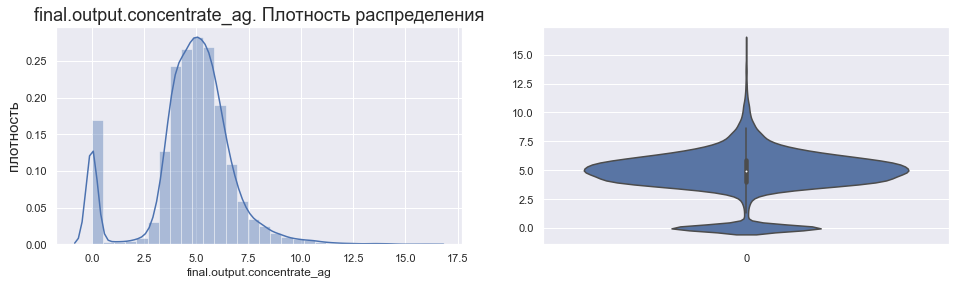

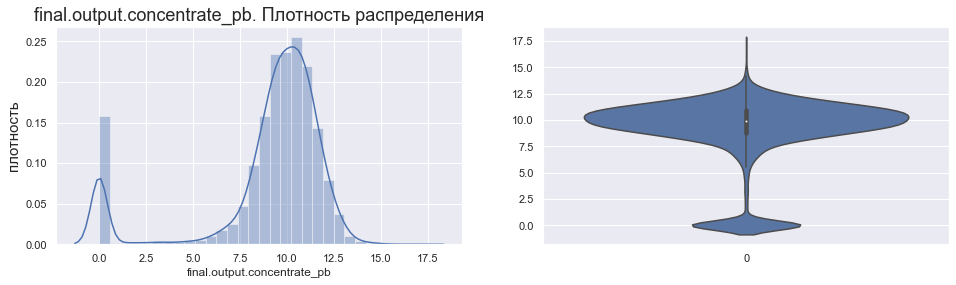

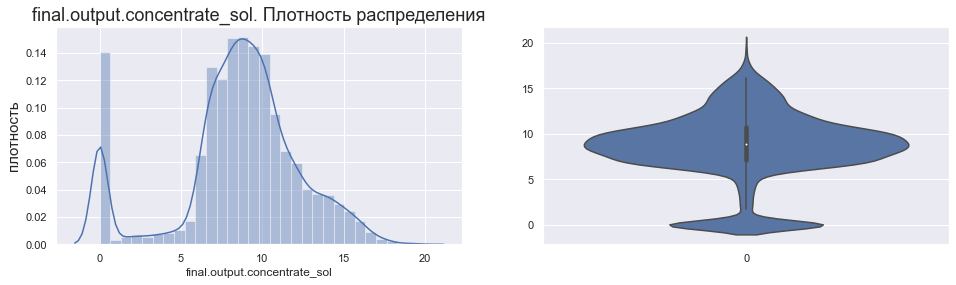

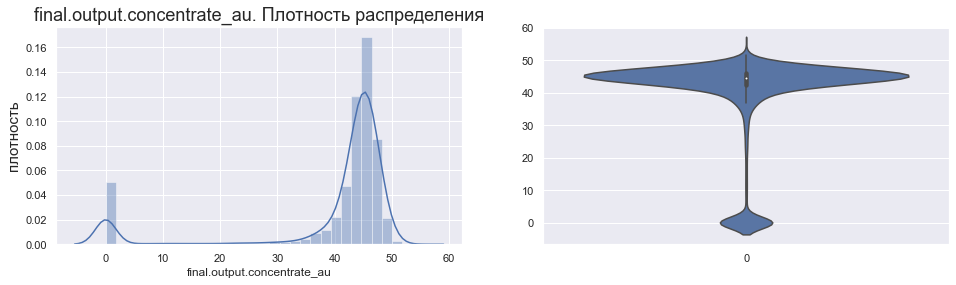

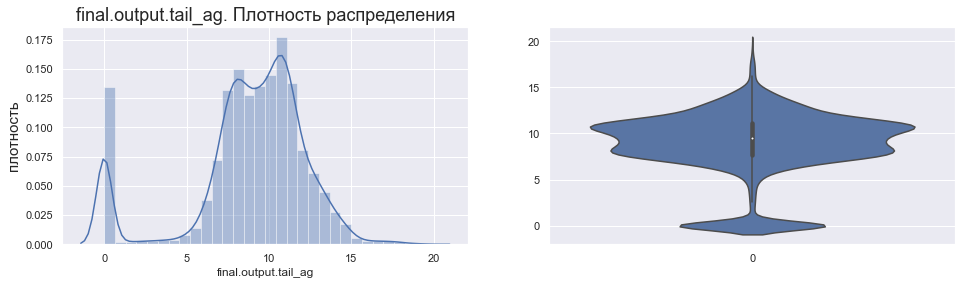

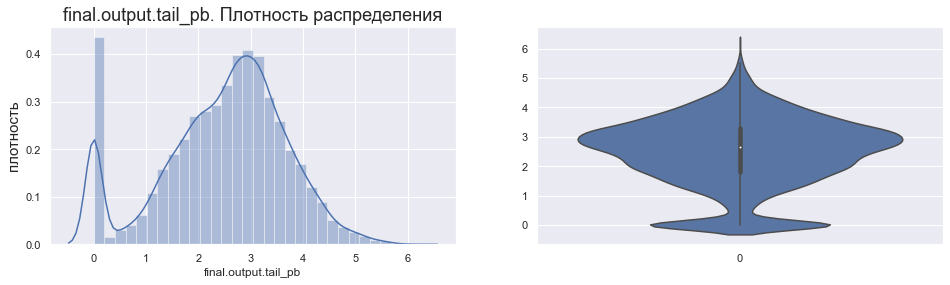

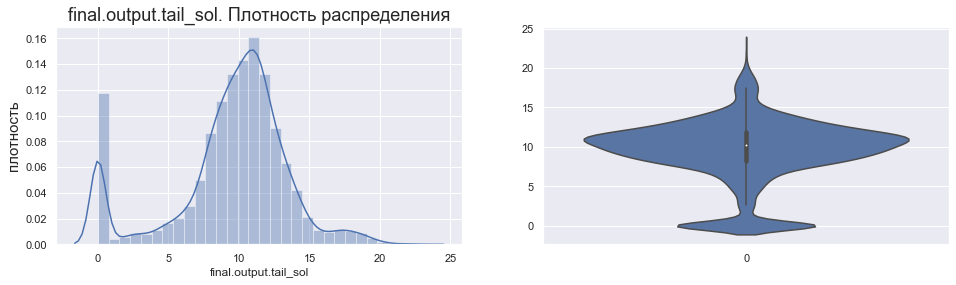

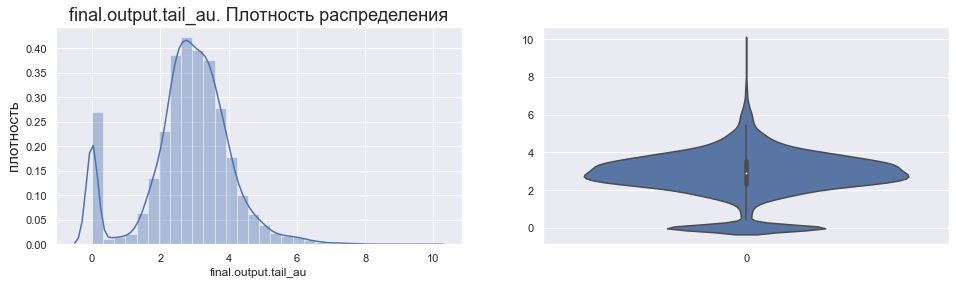

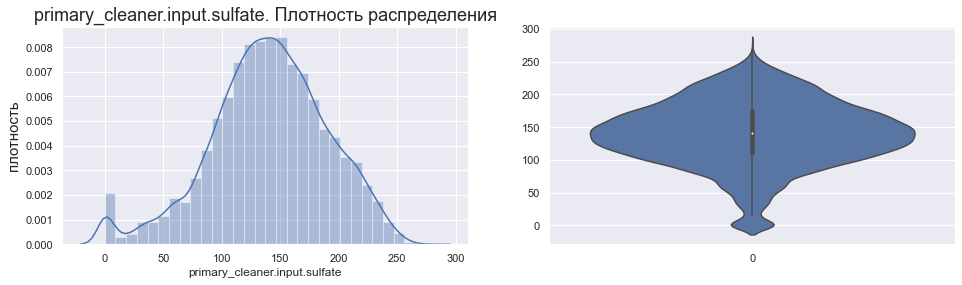

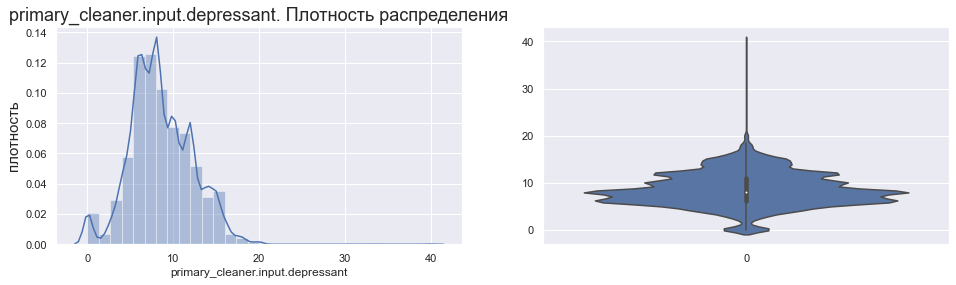

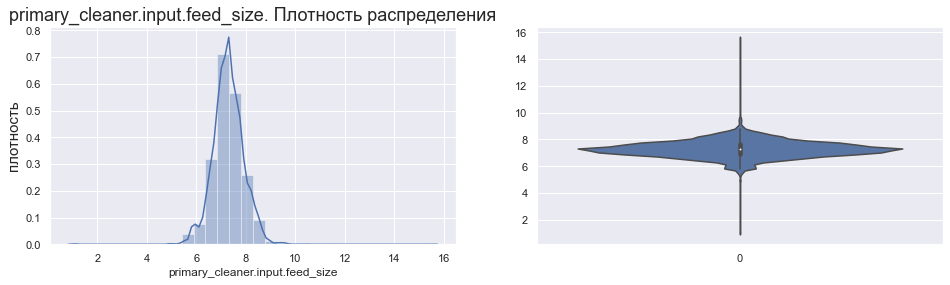

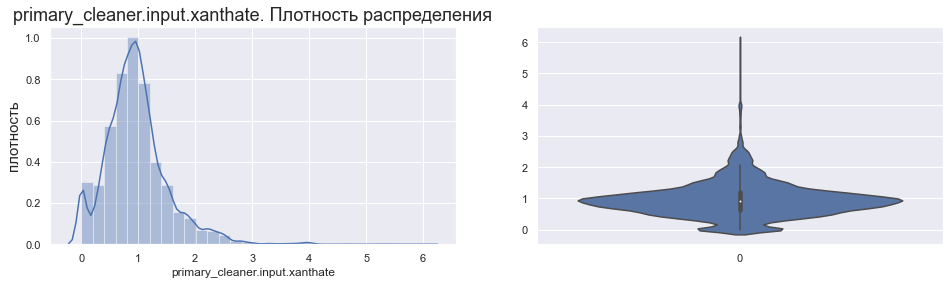

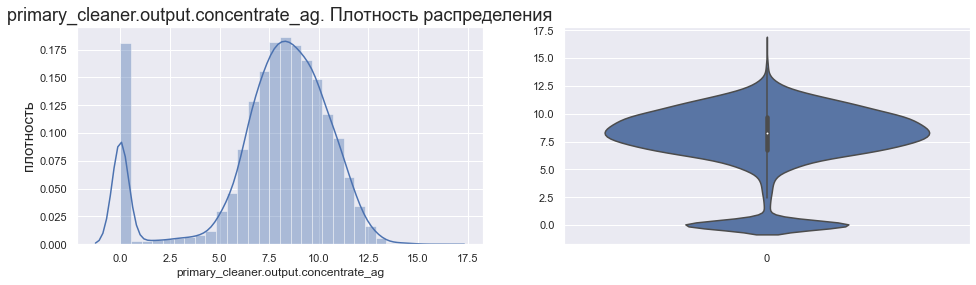

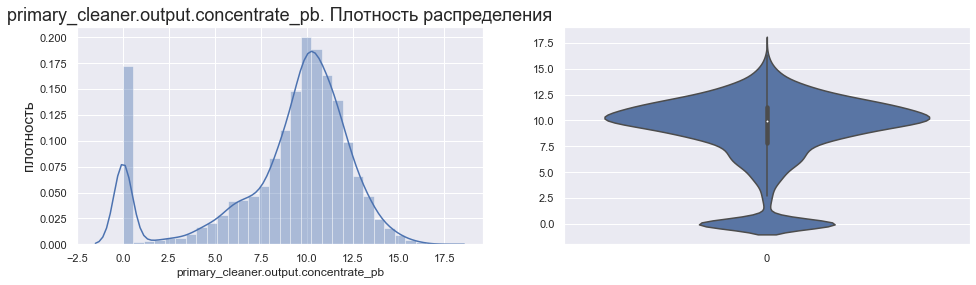

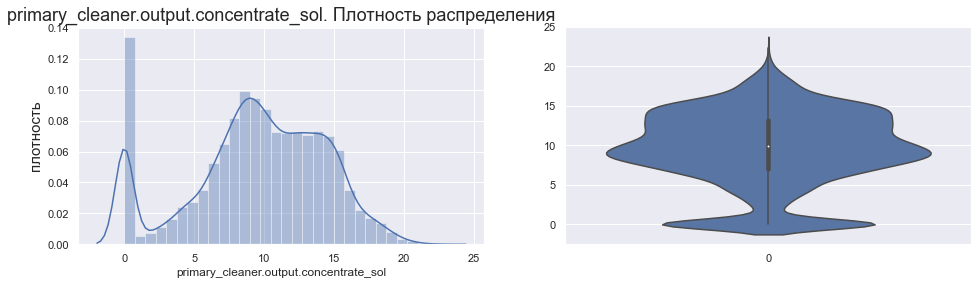

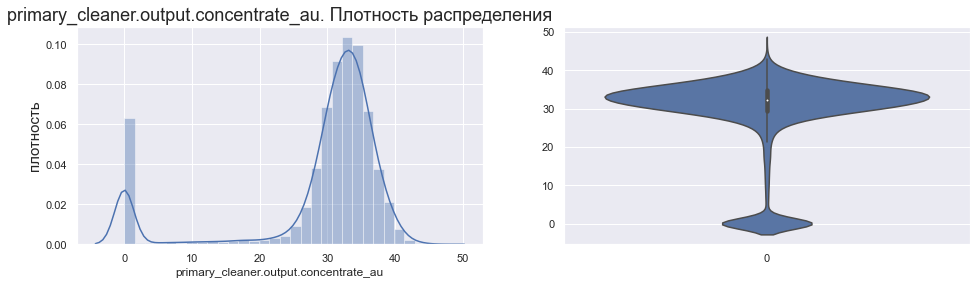

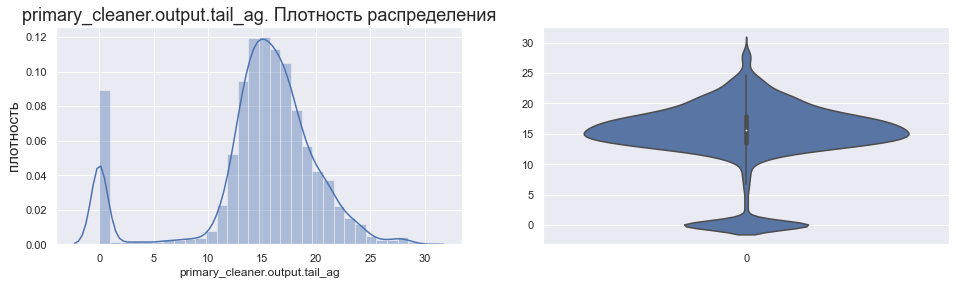

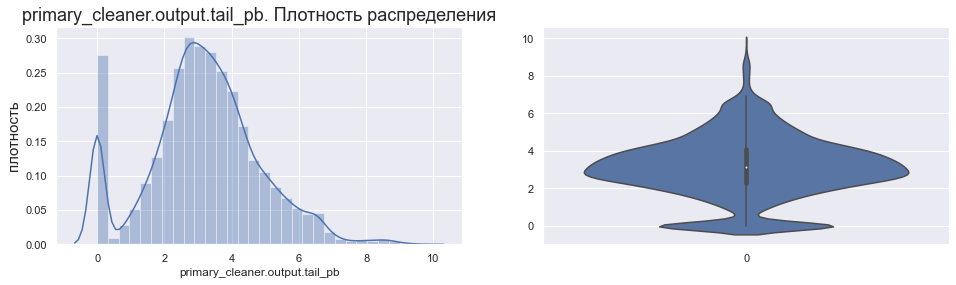

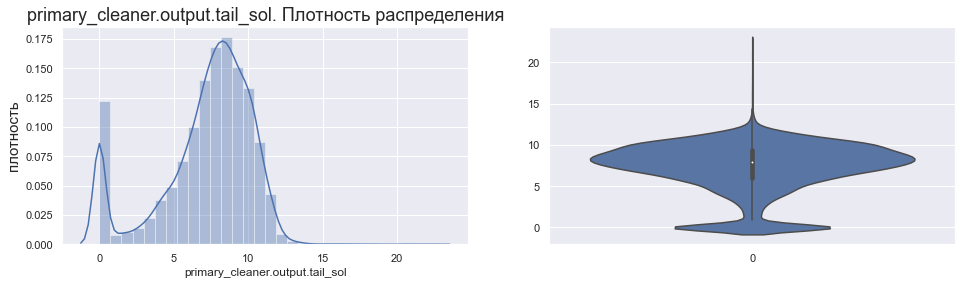

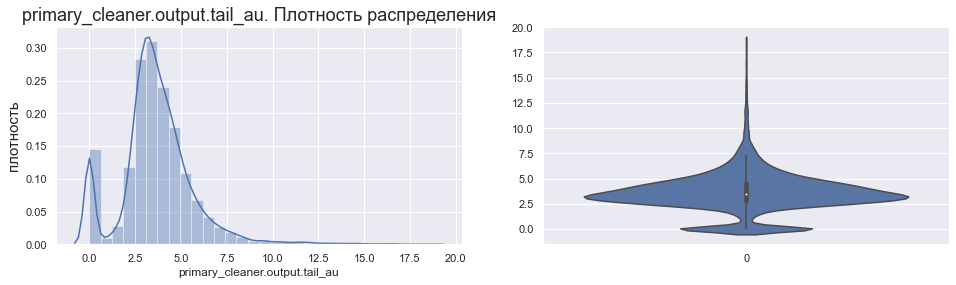

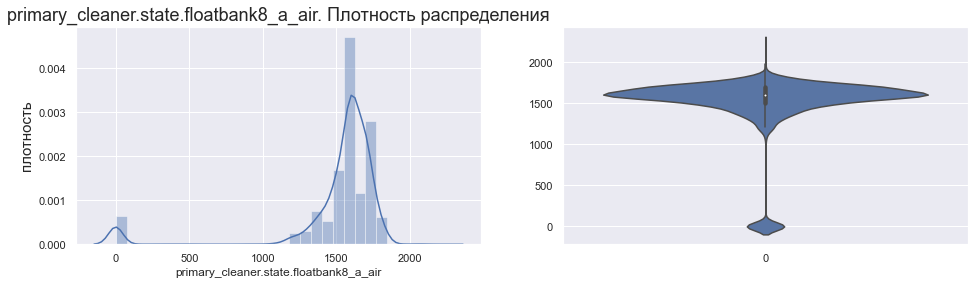

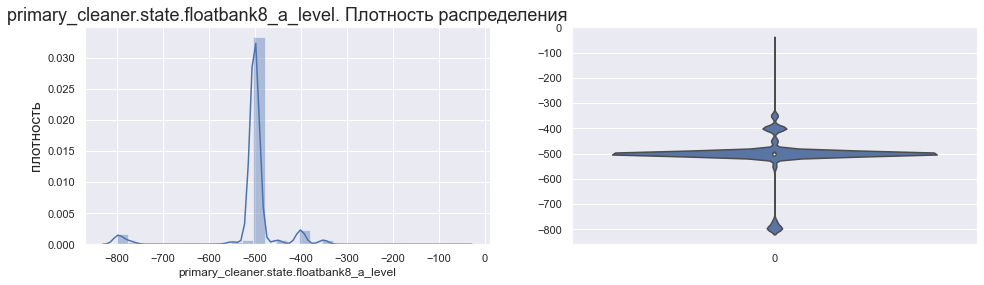

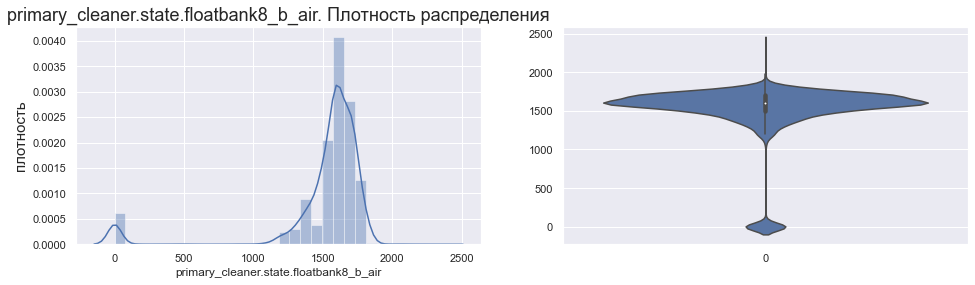

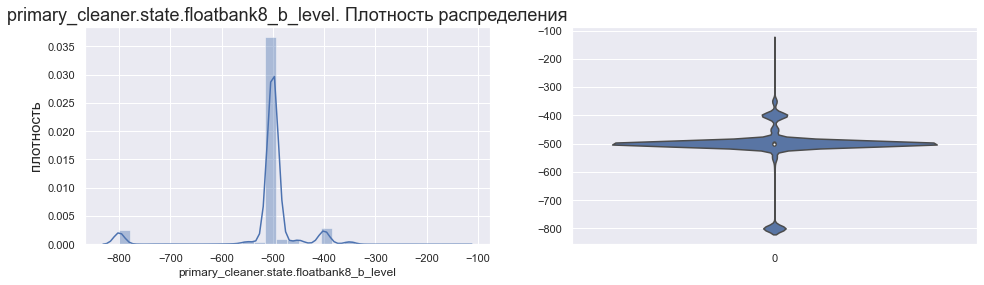

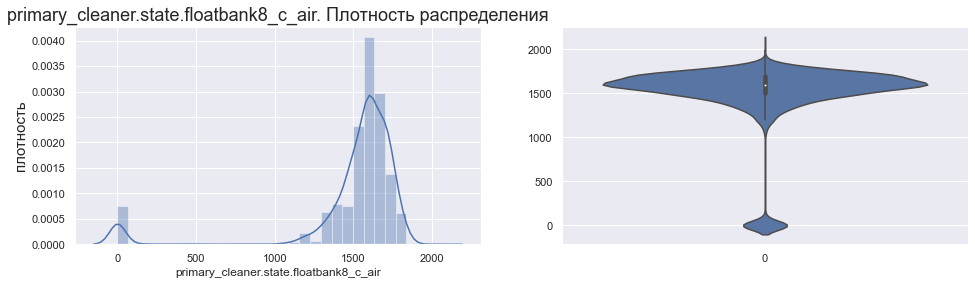

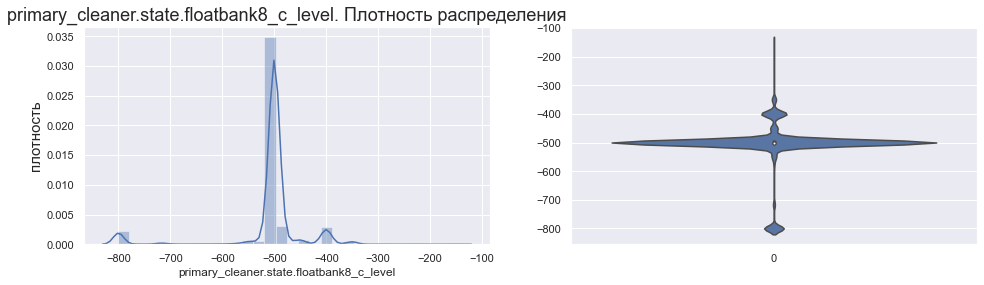

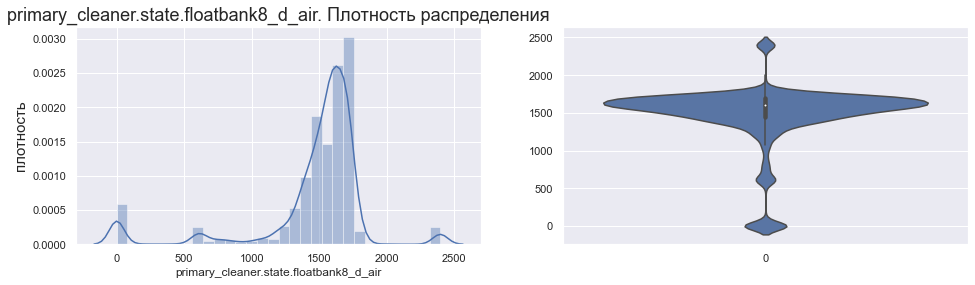

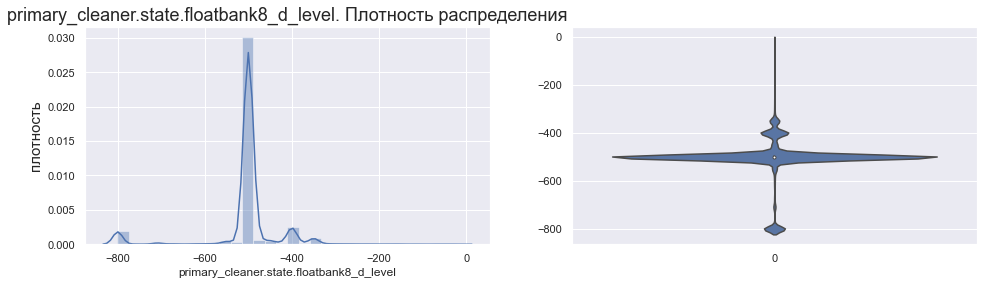

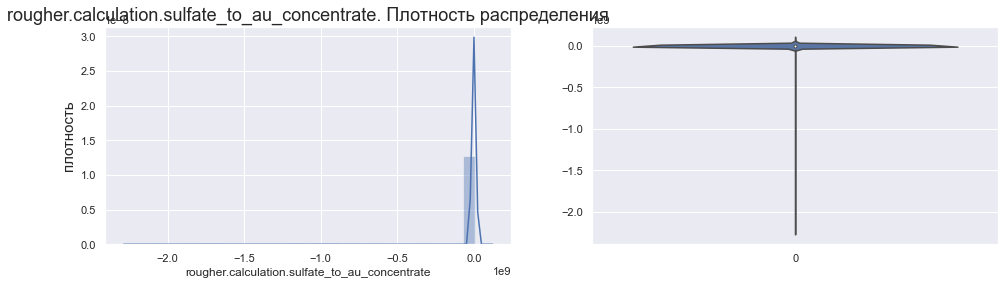

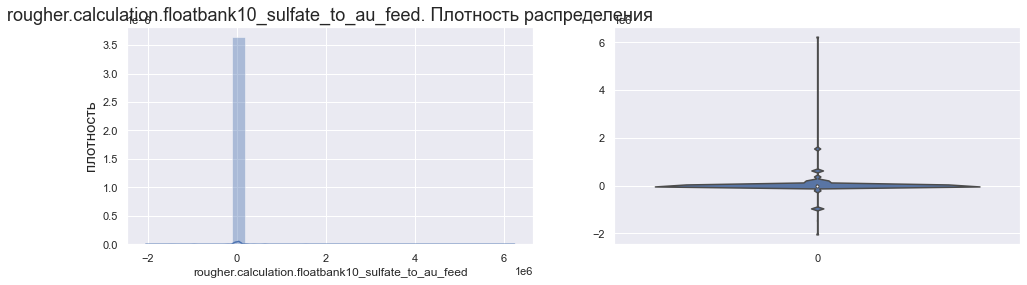

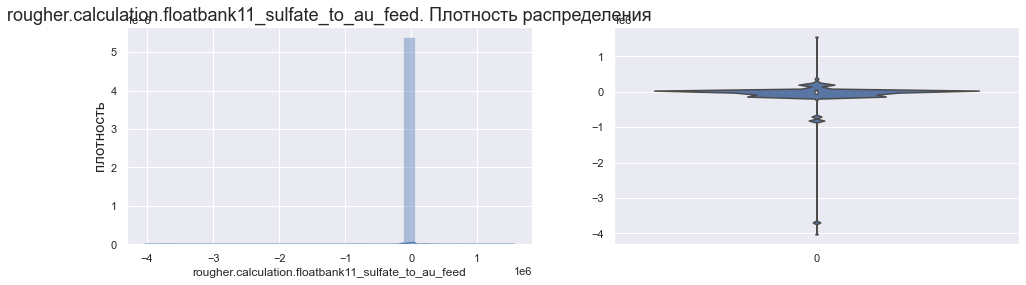

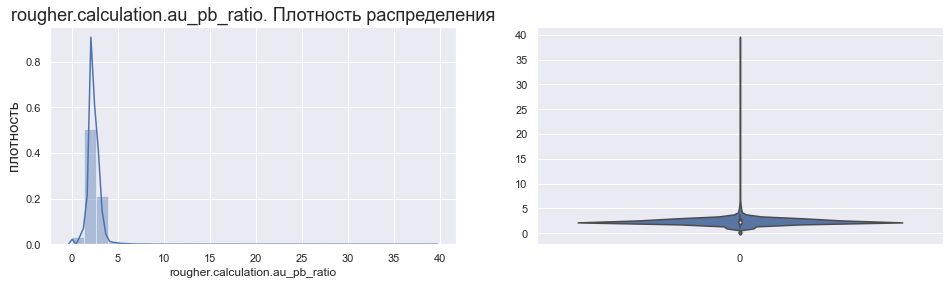

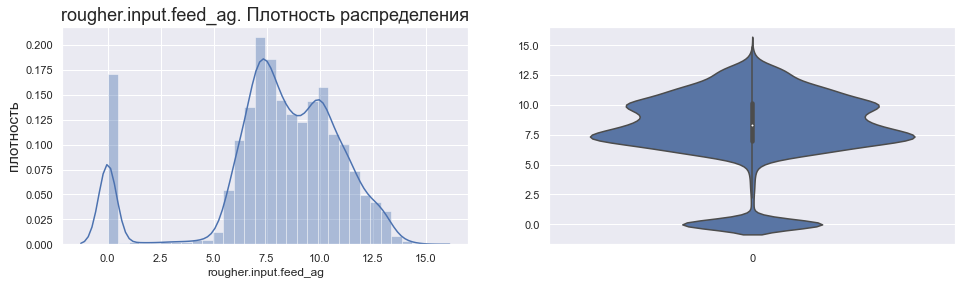

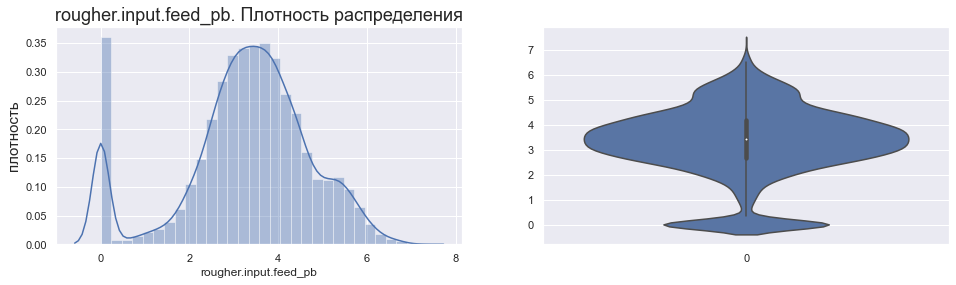

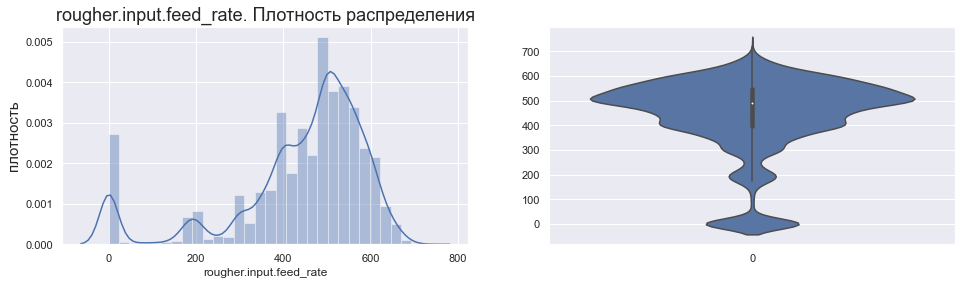

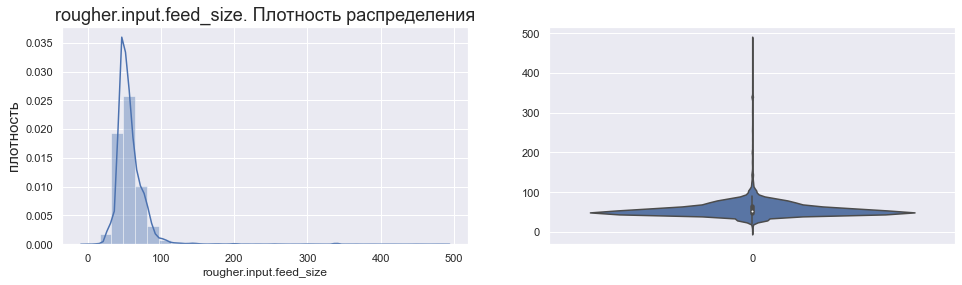

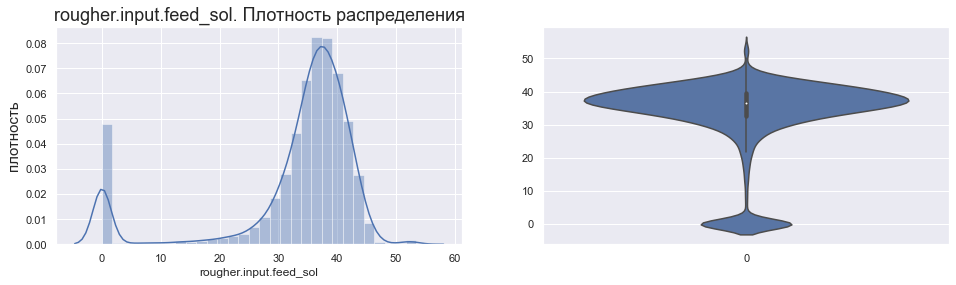

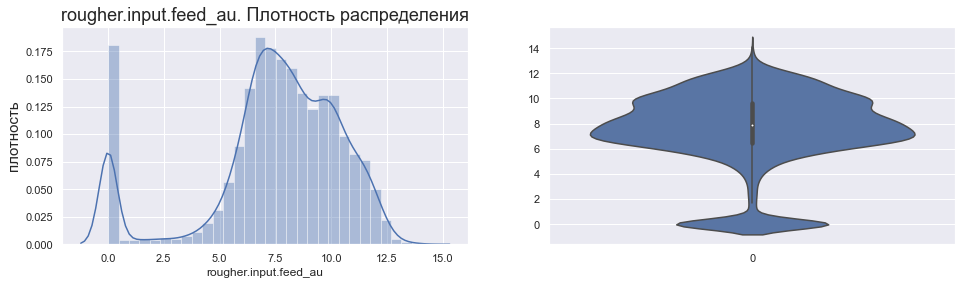

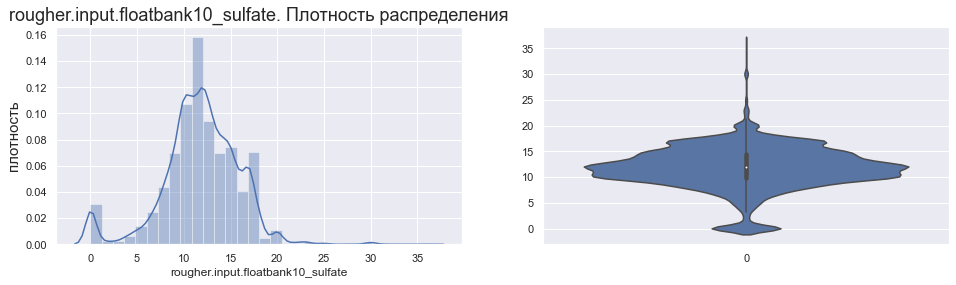

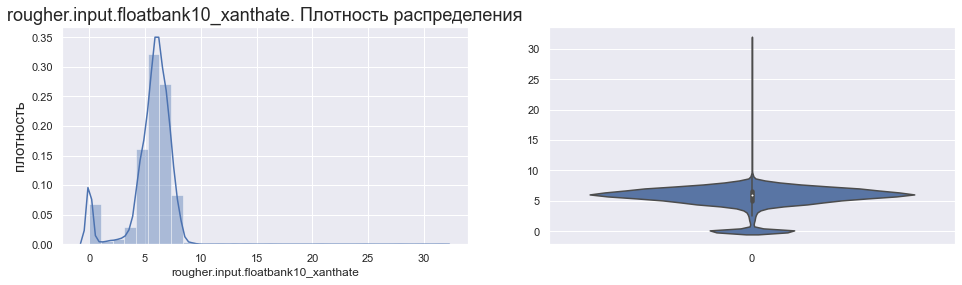

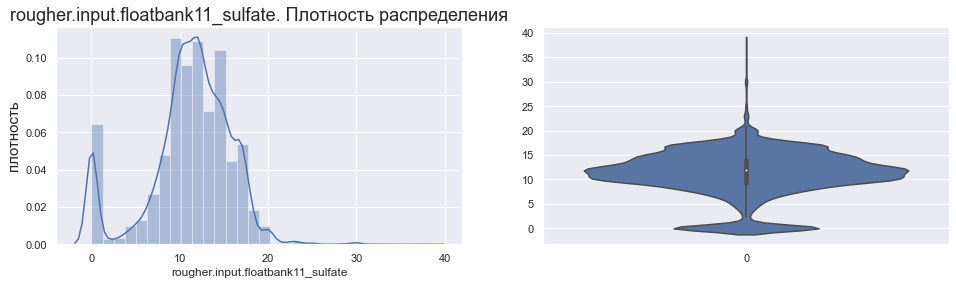

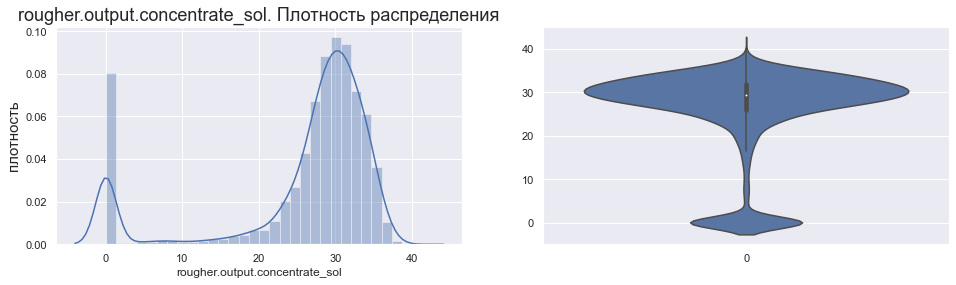

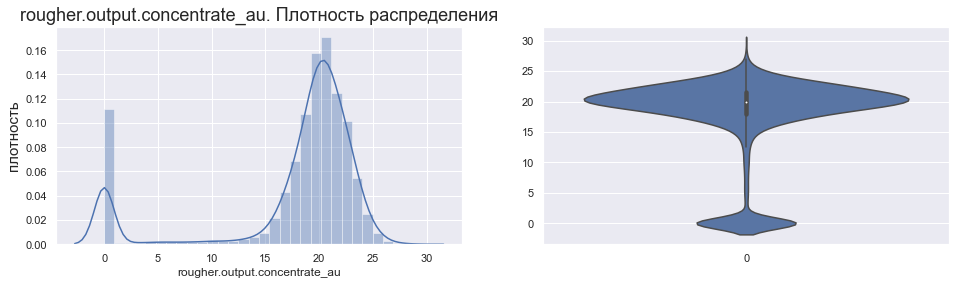

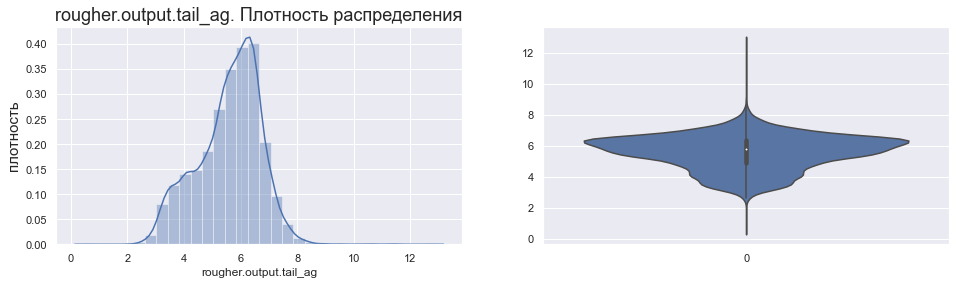

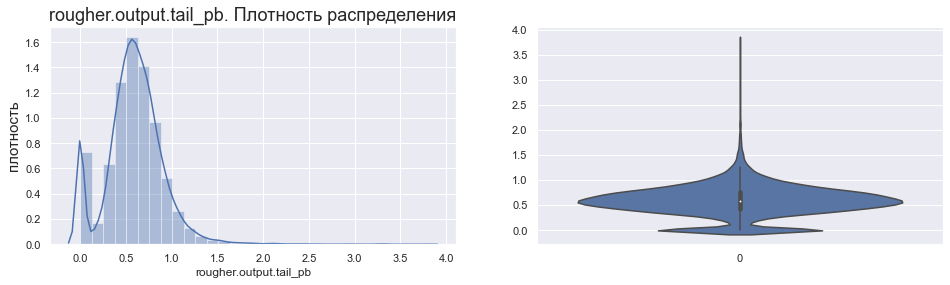

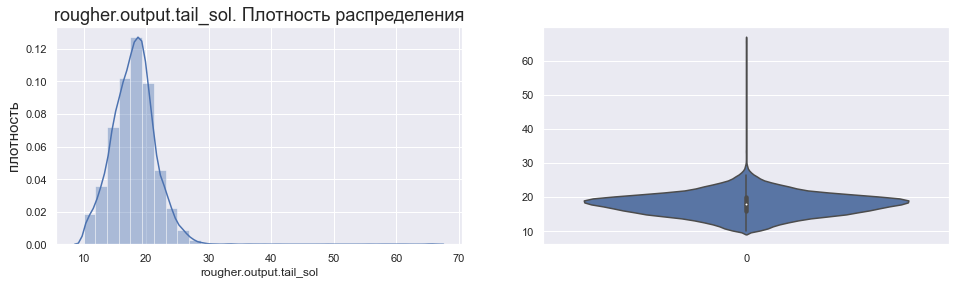

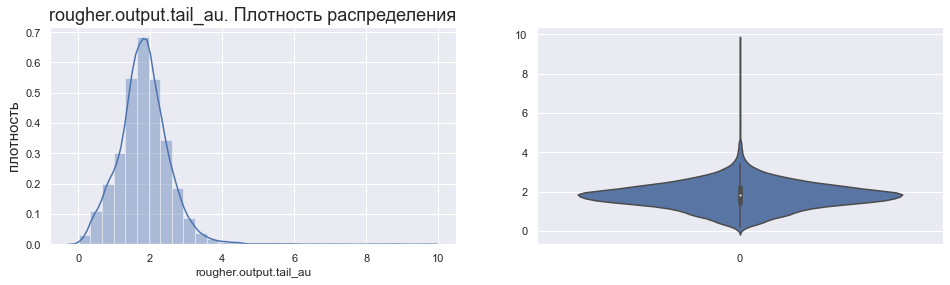

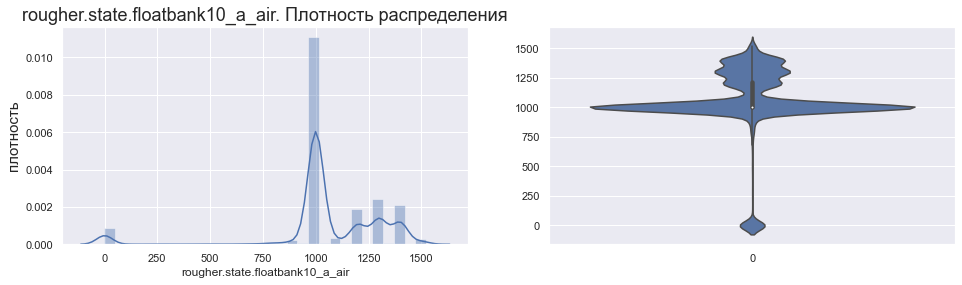

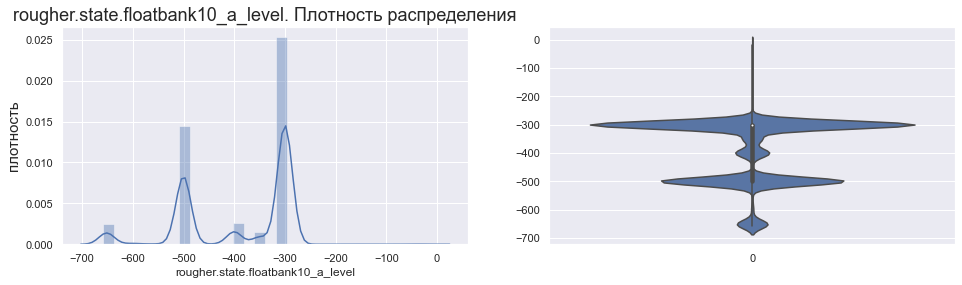

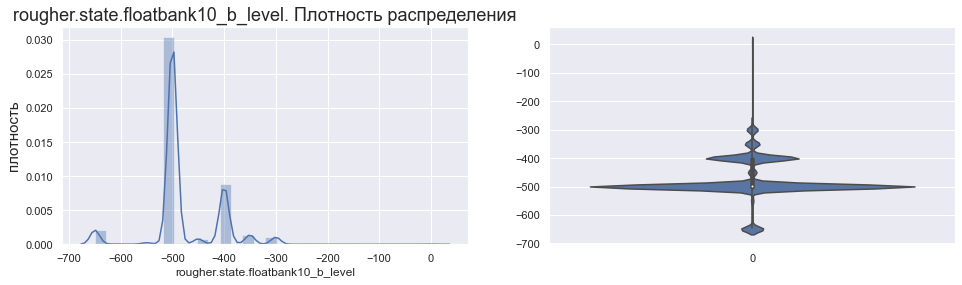

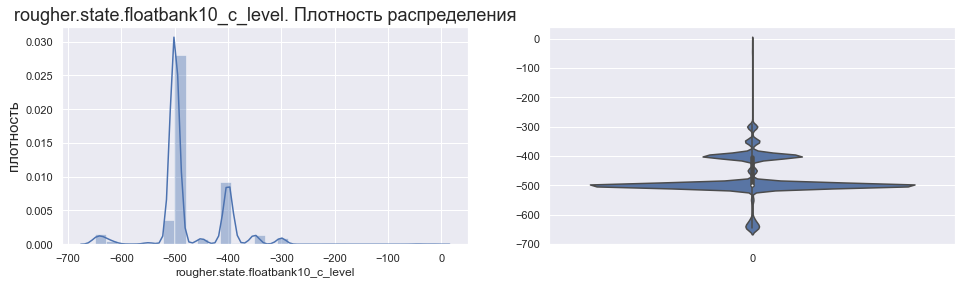

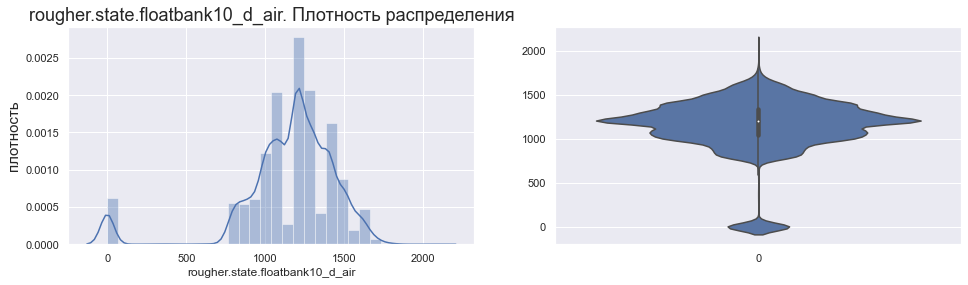

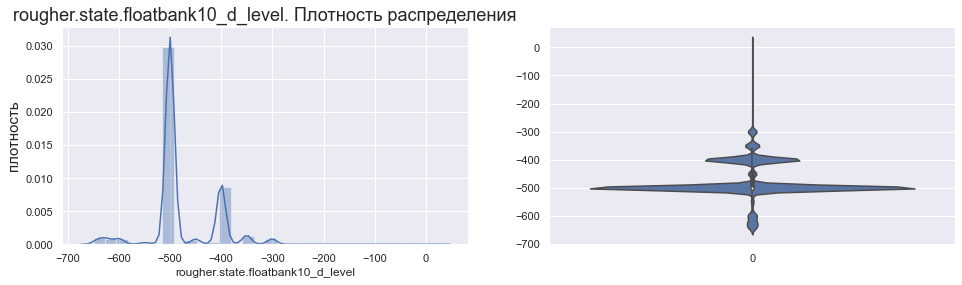

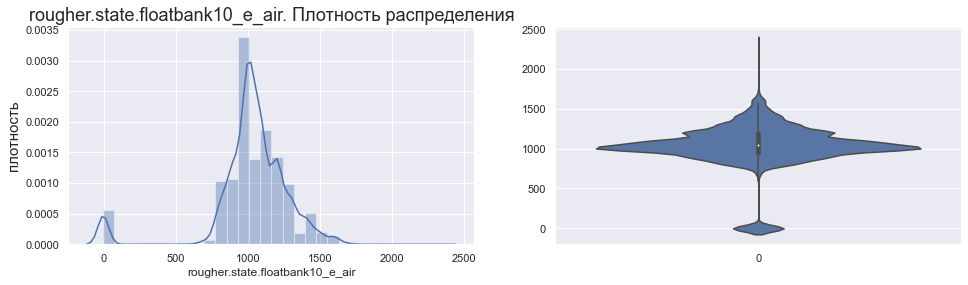

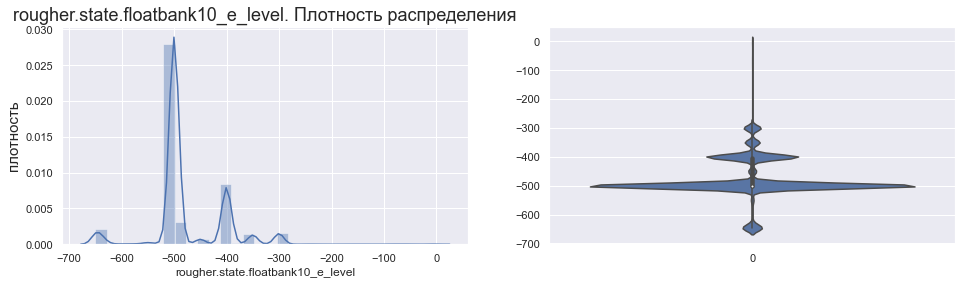

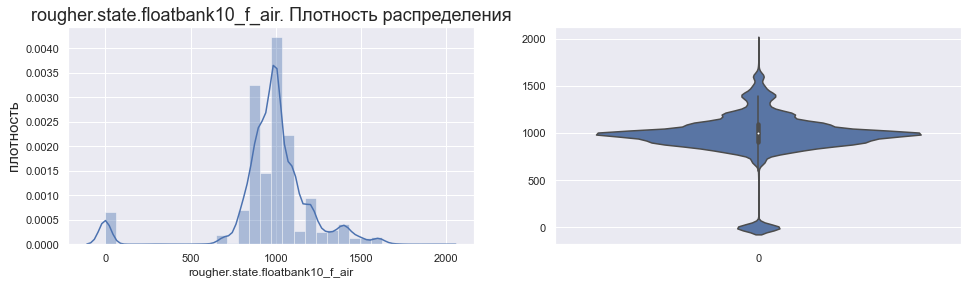

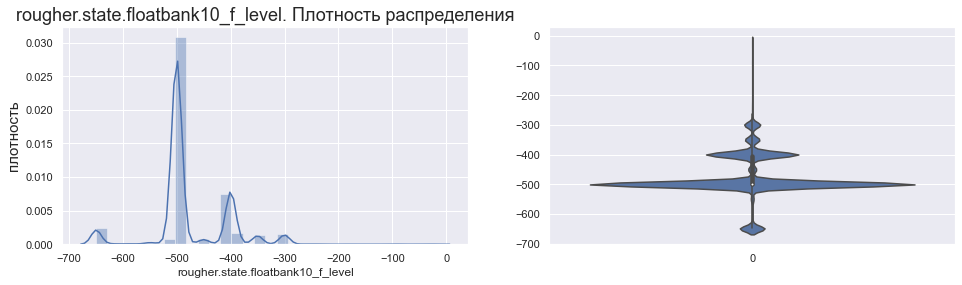

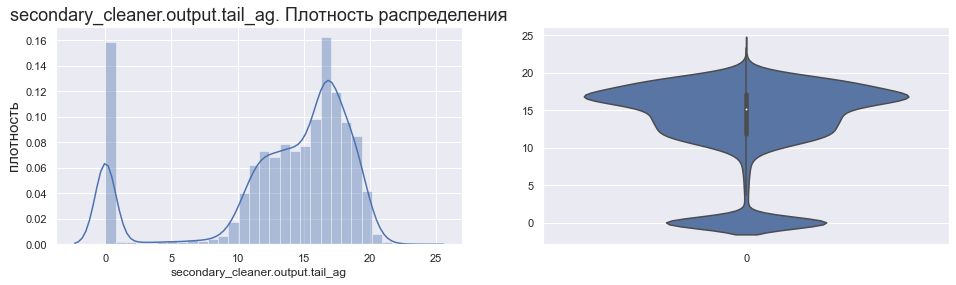

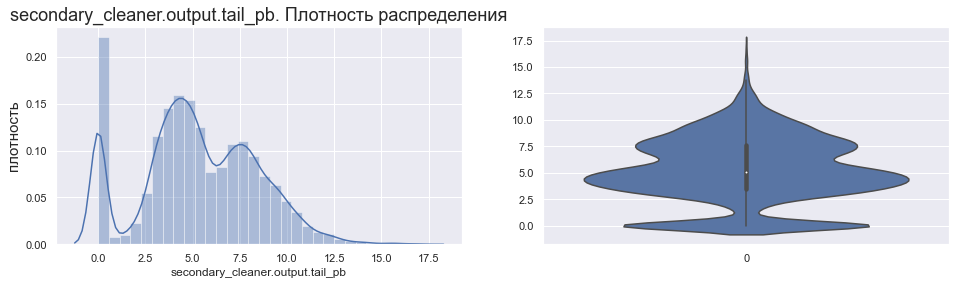

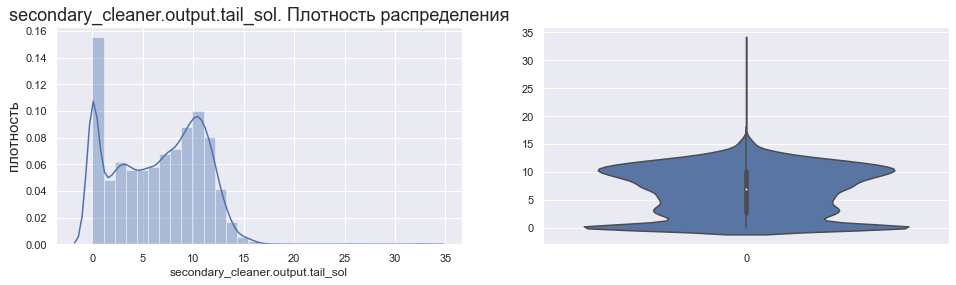

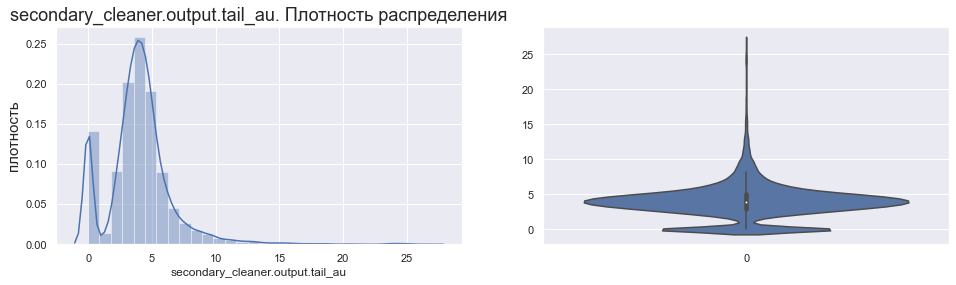

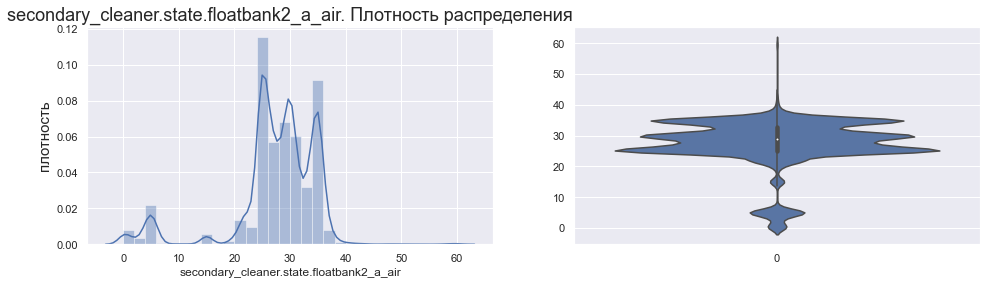

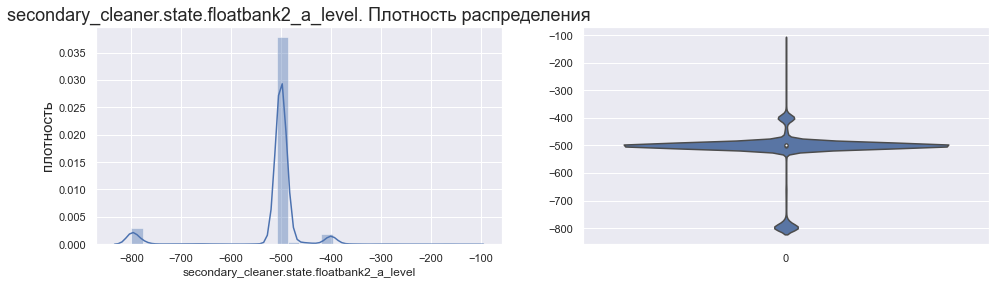

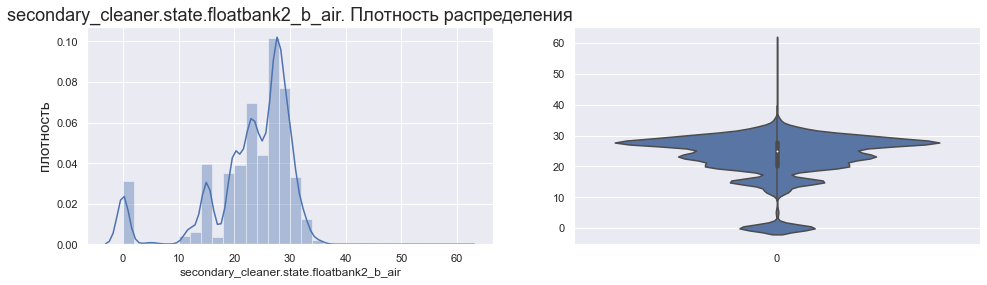

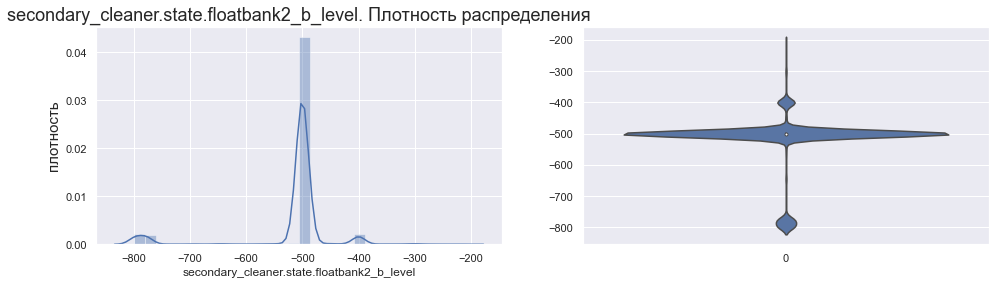

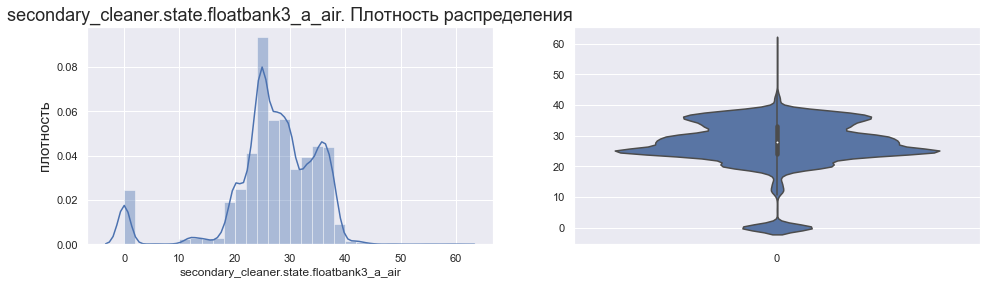

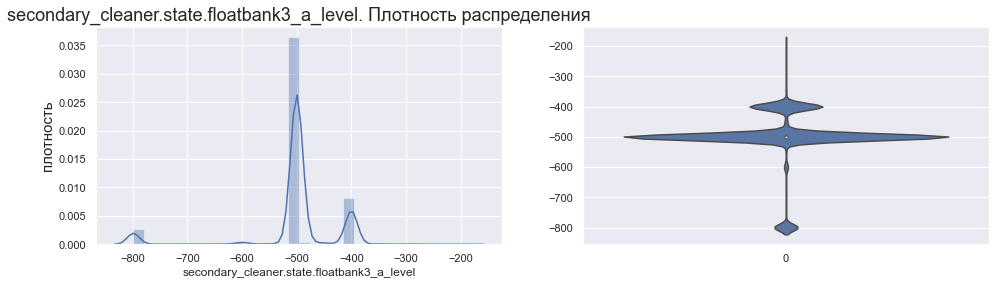

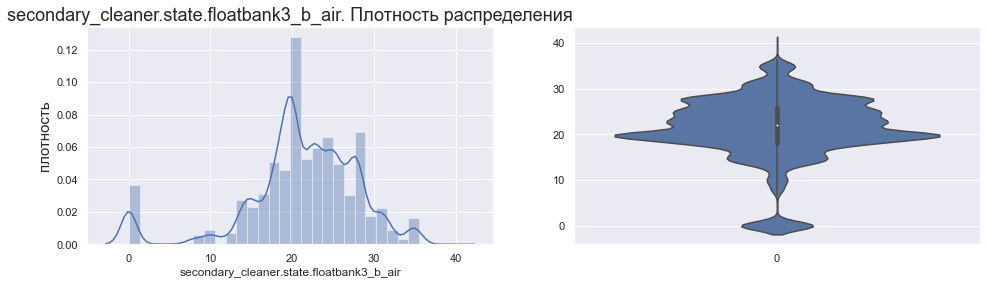

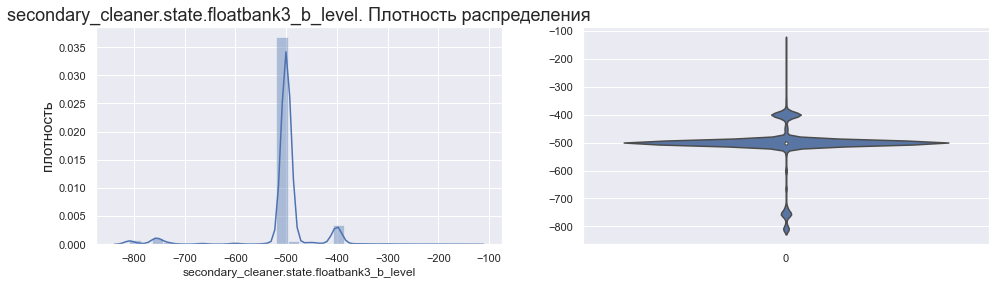

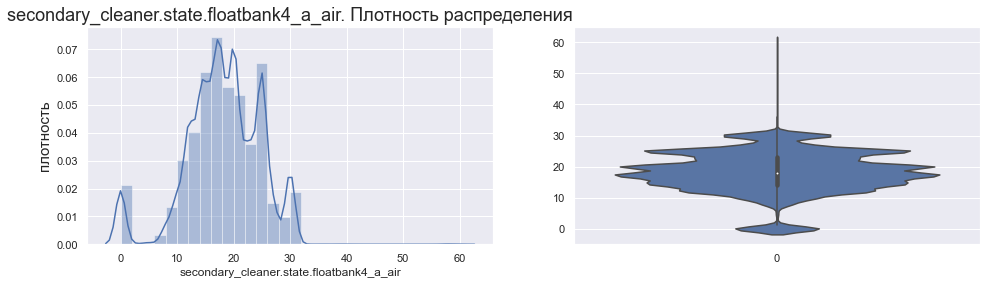

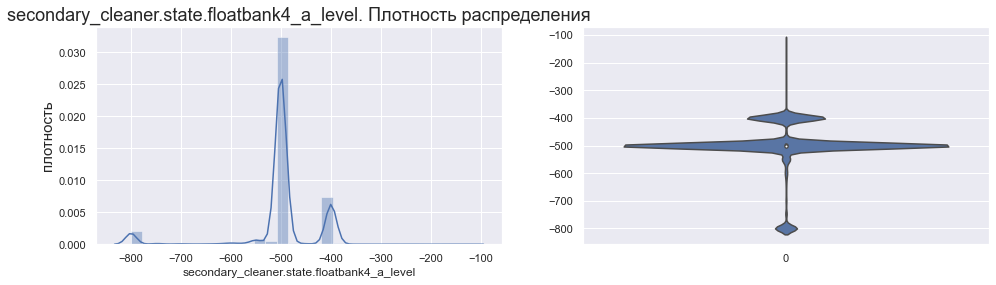

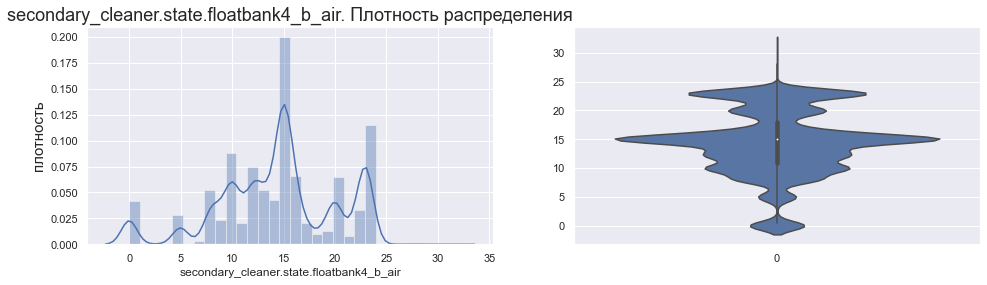

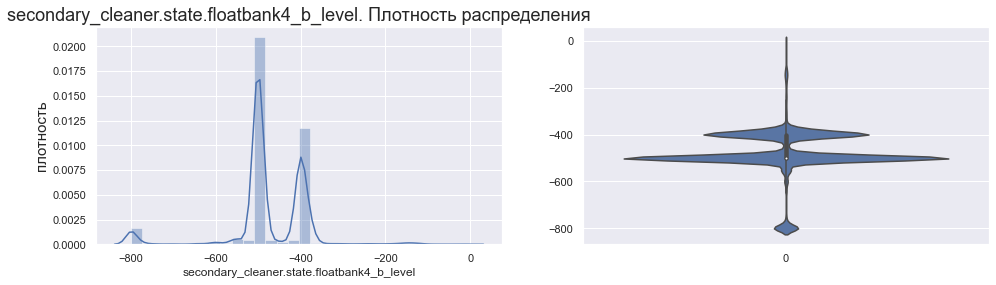

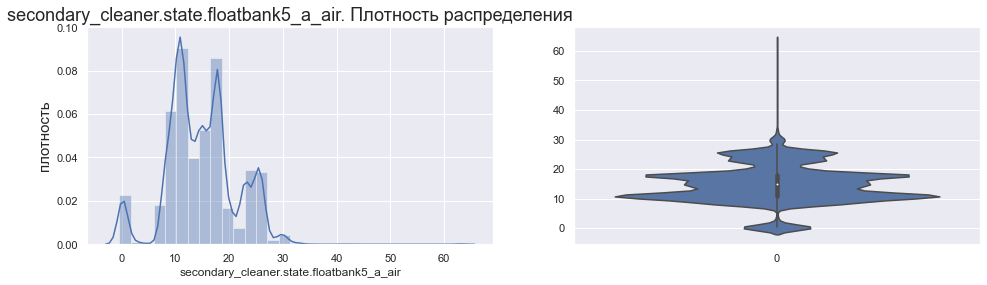

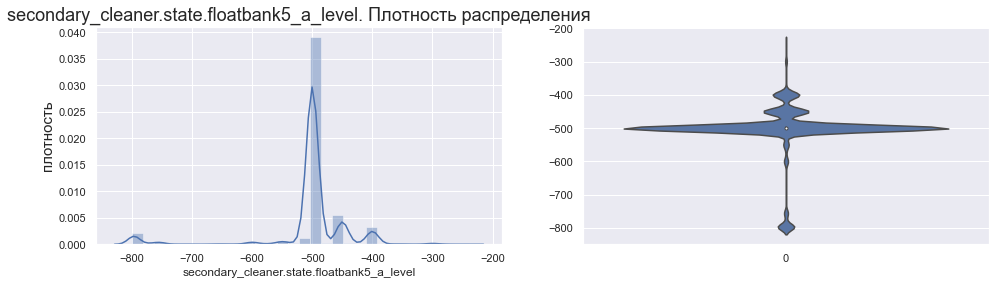

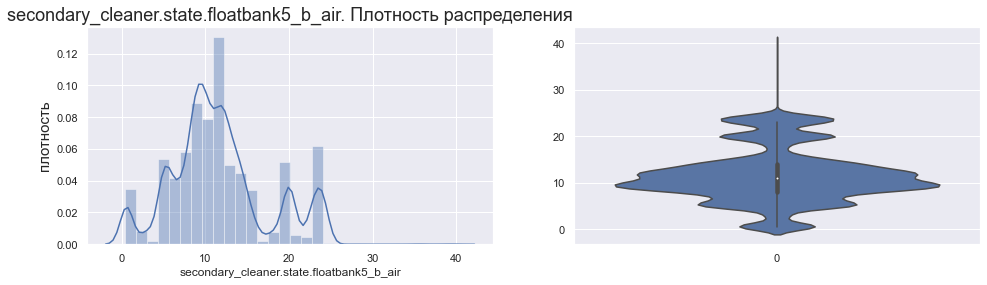

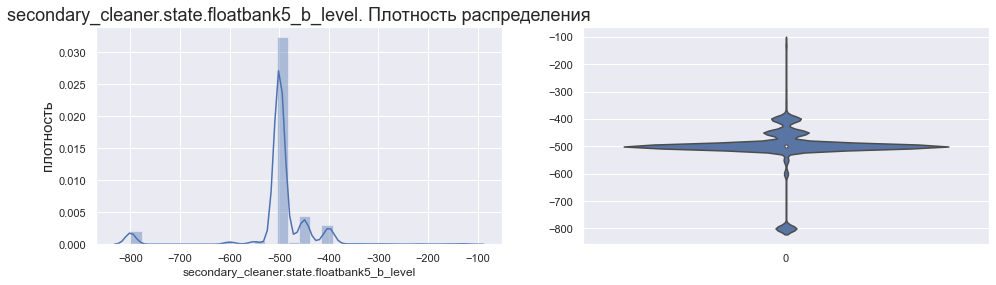

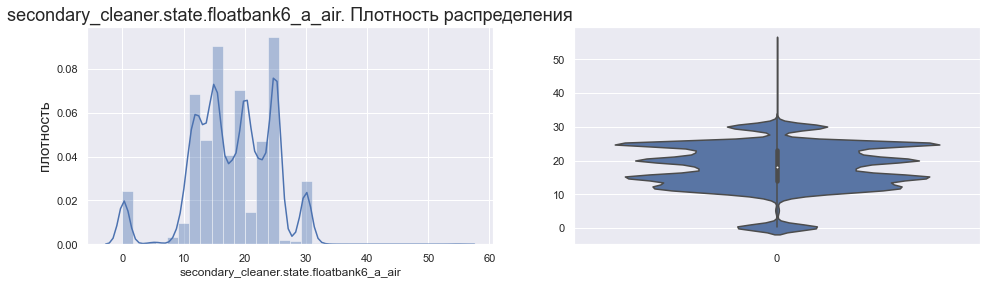

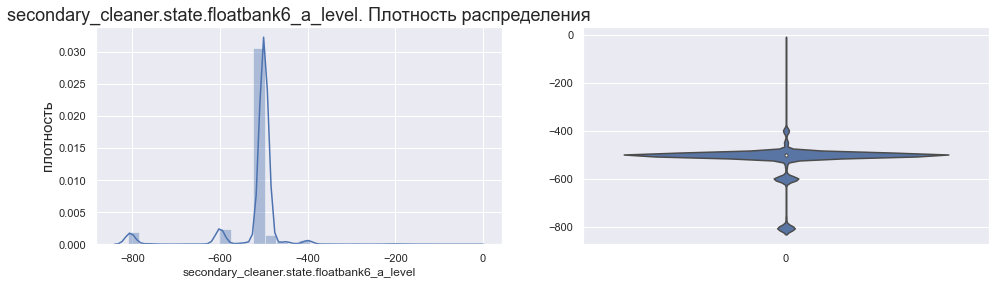

In [8]:
for column in full.columns:
    show_hists(full[column], column, num_bins=30)

- Распределения некоторых признаков отличаются от нормального. 
- Также присутствуют большие выбросы. После отбора признаков необходимо уменьшить их влияние на финальную модель (удалить выбросы, или прологарифмировать признак)
- Масштабы распределений отдельных признаков сильно отличаются друг от друга (более одного порядка). Отобранные признаки будут нуждаться в масштабировании.

## 1.2 Проверка расчётов эффективности обогащения

- Проверим, что эффективность обогащения рассчитана правильно. 
    - Вычислим recovery на обучающей выборке `train` для признака `rougher.output.recovery` (этап флотации). 
    - Найдём MAE между расчётами и значением признака.

In [9]:
# расчёт эффективности обогащения золота на этапе флотации
C = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.output.concentrate_au']
F = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.input.feed_au']
T = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.output.tail_au']
rough_recov_calc = C * (F - T) / (F * (C - T)) * 100
rough_recov_train = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.output.recovery']

In [10]:
# расчёт sMAPE 
numer = abs(rough_recov_train - rough_recov_calc)
denom = 0.5 * (abs(rough_recov_train) + abs(rough_recov_calc))
N = len(rough_recov_train)
smae_rough_rec = 1 / N * (numer / denom).sum() * 100
print("Показатель sMAPE для 'Эффективности обогащения золота на этапе флотации'")
print("между рассчитанным значением и тренировочной выборкой: {0:.2E}".format(smae_rough_rec))

Показатель sMAPE для 'Эффективности обогащения золота на этапе флотации'
между рассчитанным значением и тренировочной выборкой: 1.16E-14


- sMAPE ничтожно мало, следовательно, показатель рассчитан верно. Предположим, что и остальные показатели `recovery` рассчитаны верно.
- Попробуем заполнить признак `rougher.output.recovery` в обучающей выборке по имеющимся данным

## 1.3 Анализ признаков, недоступных в тестовой выборке

In [11]:
[col for col in list(train.columns) if (col not in list(test.columns))]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

- В тестовой выборке отсутствуют выходные параметры продукта `output` на каждом этапе техпроцесса. Это концентраты и "отвальные хвосты" для металлов (Au, Ag, Pb) и солей, а также рассчитанное `recovery` на разных этапах. Эти данные в любом случае не подходят для тренировки модели, так как появляются во время или после измерения целевых признаков.
- Также в тестовой выборке отсутствуют расчётные признаки на этапе флотации `rougher.calculation` (концентрация сульфатов относительно золота, соотношение золота и свинца, и др.). 
- Данные признаки не будут участвовать в построении модели.

## 1.4 Предобработка данных

- Не все признаки подойдут для обучения модели. 
    - Отберём те, которые больше всего коррелируют с целевыми признаками `final.output.recovery`, `rougher.output.recovery`. 
    - Также удалим признаки, сильно коррелирующие с уже отобранными. Добавление таких признаков не увеличит качество модели, но увеличит её сложность и, возможно, дисперсию предсказаний.
- Среди отобранных признаков рассмотрим пропуски и аномалии.

In [12]:
input_columns = list(test.columns)
model_columns = ['final.output.recovery', 'rougher.output.recovery'] + input_columns

In [13]:
(train[model_columns].corr()
 .sort_values(by = 'final.output.recovery', ascending = False)
 .style.background_gradient(cmap = 'coolwarm')
)

In [14]:
columns_to_drop = ['primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_b_air', 
                   'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_c_level',
                   'primary_cleaner.state.floatbank8_d_level', 'rougher.input.floatbank10_sulfate',
                   'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_b_air',
                   'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air', 
                   'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
                   'rougher.state.floatbank10_f_level', 'secondary_cleaner.state.floatbank2_a_air',
                   'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank4_b_air',
                   'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level',
                   'rougher.state.floatbank10_b_level']

In [15]:
model_columns = [column for column in model_columns if column not in columns_to_drop]
input_columns = [column for column in input_columns if column not in columns_to_drop]

- Выбранные для удаления признаки относятся к параметрам, характеризующим текущее состояние этапов технологического процесса. Скорее всего, они напрямую связаны с оставшимися признаками (уровни жидкости и объёмы воздуха в разных `floatbank` напрямую зависят друг от друга). Возможно, так настроен процесс работы, и лишние признаки можно удалить. Но так может быть не всегда. Если зависимости между признаками изменятся в будущем (уровни жидкости и объёмы газа в разных `floatbank` станут независимыми), разработанная регрессионная модель может потерять свою актуальность. Необходимо следить за данными параметрами и в случае необходимости обновить модель.
- Удалим выбранные признаки

In [16]:
train = train.drop(columns_to_drop, axis = 1)
test = test.drop(columns_to_drop, axis = 1)

In [17]:
set(train) == set (test)

False

- Единственный признак с большим количеством пропусков `rougher.input.floatbank11_xanthate`. Он сильно коррелирует с признаком
`rougher.input.floatbank10_xanthate`. Признаки определяют количество активатора на входе флотации. Рассмотрим их совместное распределение на диаграмме рассеяния.

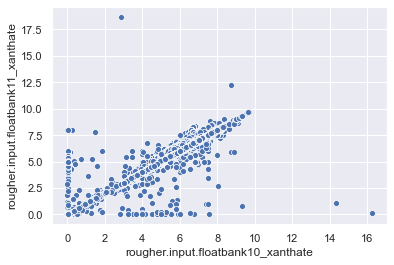

In [18]:
sns.scatterplot(x = 'rougher.input.floatbank10_xanthate', y = 'rougher.input.floatbank11_xanthate', data = full)

Оба признака распределены практически одинаково и в большинстве случаев повторяют друг друга. Заполним пропуски для `floatbank11` известными значениями из `floatbank10`

In [19]:
train['rougher.input.floatbank11_xanthate'] = (train['rougher.input.floatbank11_xanthate']
                                               .fillna(full['rougher.input.floatbank10_xanthate']))
test['rougher.input.floatbank11_xanthate'] = (test['rougher.input.floatbank11_xanthate']
                                               .fillna(full['rougher.input.floatbank10_xanthate']))

- попробуем заполнить значения пропущенных целевых признаков по имеющимся данным.

In [20]:
# расчёт эффективности обогащения золота на этапе флотации
C = train.loc[train['rougher.output.recovery'].isna(), 'rougher.output.concentrate_au']
F = train.loc[train['rougher.output.recovery'].isna(), 'rougher.input.feed_au']
T = train.loc[train['rougher.output.recovery'].isna(), 'rougher.output.tail_au']
train.loc[train['rougher.output.recovery'].isna(), 'rougher.output.recovery'] = C * (F - T) / (F * (C - T)) * 100

In [21]:
print('Количество пропусков recovery на этапе флотации:', sum(train['rougher.output.recovery'].isna()))

Количество пропусков recovery на этапе флотации: 2199


- Среди оставшихся признаков практически все имеют пропуски. Но их количество невелико (около 1-2 %). Заполним их значениями в соседних объектах (данные в таблице расположены по времени, и значения соседних объектов мало отличаются друг от друга).

In [22]:
train[input_columns] = train[input_columns].fillna(method='ffill')
test = test.fillna(method='ffill')

- Исследование выбросов проведём при анализе суммарной концентрации всех веществ в пункте 2.

### Выводы

- Данные успешно загружены и проанализированы. Данные соответствуют описанию, дубликатов нет.
- Показатель эффективности обогащения рассчитан корректно.
- В тестовой выборке отсутствуют параметры продукта, а также расчётные признаки на этапе флотации. Данные параметры не будут учасвовать в построении модели.
- Отобраны признаки, избыточные для модели (некоторые параметры, характеризующие текущее состояние этапов технологического процесса). Они не будут участвовать в построении модели. В случае изменения технологического процесса поведение данных признаков может измениться, и будет необходимо обновить модель.
- Для актуальных признаков были заполнены пропуски на основе имеющихся исторических данных.

# 2. Анализ данных

## 2.1 Анализ изменения концентрации металлов (Au, Ag, Pb)

- Для анализа концентрации металлов взглянем на графики изменения графики зависимости концентрации по времени (для каждого этапа) и на графики изменения средних показателей от этапа очистки.

In [23]:
train = train.set_index(pd.DatetimeIndex(train.index))
test = test.set_index(pd.DatetimeIndex(test.index))
full = full.set_index(pd.DatetimeIndex(full.index))

In [24]:
met_concs = np.array([['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'],
                      ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'],
                      ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
                    )

In [25]:
def plot_met_time(cols, label):
    sns.set()
    f, axes = plt.subplots(1, 1, figsize=(16, 6))
    axes.set_title(label, fontsize=18)
    axes.set_ylabel('концентрация', fontsize=15)
    sns.lineplot(data=train[cols].groupby(train.index.floor('D')).mean())

- Рассмотрим концентрации каждого металла отдельно для разных этапов технологического процесса.

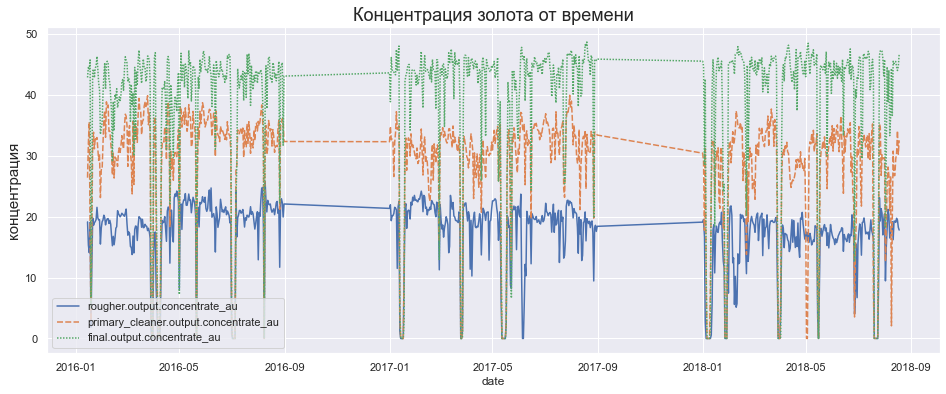

In [26]:
plot_met_time(met_concs[0], 'Концентрация золота от времени')

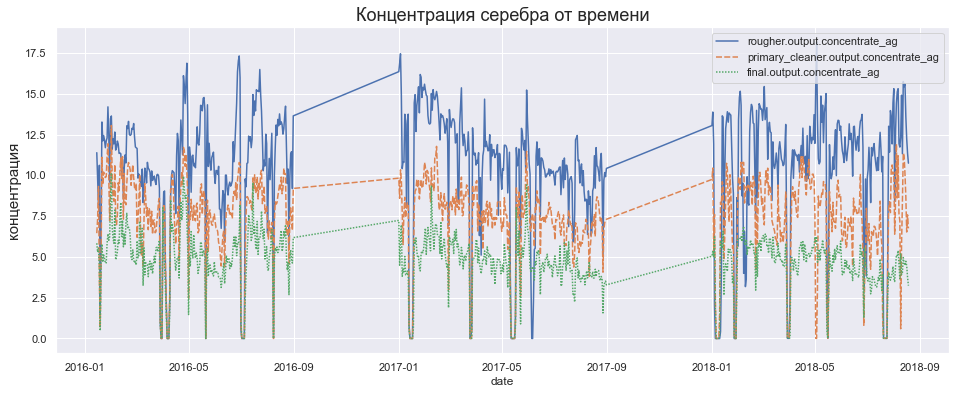

In [27]:
plot_met_time(met_concs[1], 'Концентрация серебра от времени')

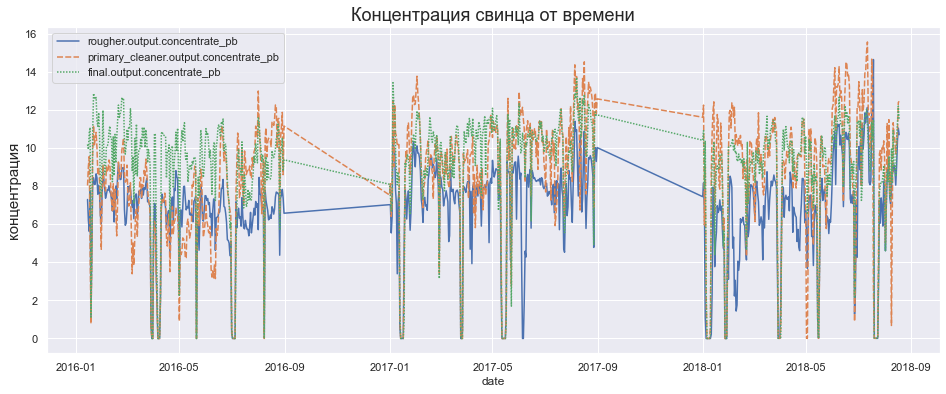

In [28]:
plot_met_time(met_concs[2], 'Концентрация свинца от времени')

- Можно заметить, что концентрация золота с каждым этапом очистки увеличивается, концентрация серебра уменьшается, концентрация свинца немного увеличивается после флотации.
- Периодически графики сваливаются в ноль. Значения неверные. В эти моменты контроль концентрации не проводился или данные были утеряны. Их следует удалить.
- Прямые линии на графике соответствуют временным промежуткам тестовой выборки.
- Теперь рассмотрим отдельно каждый этап технологического процесса

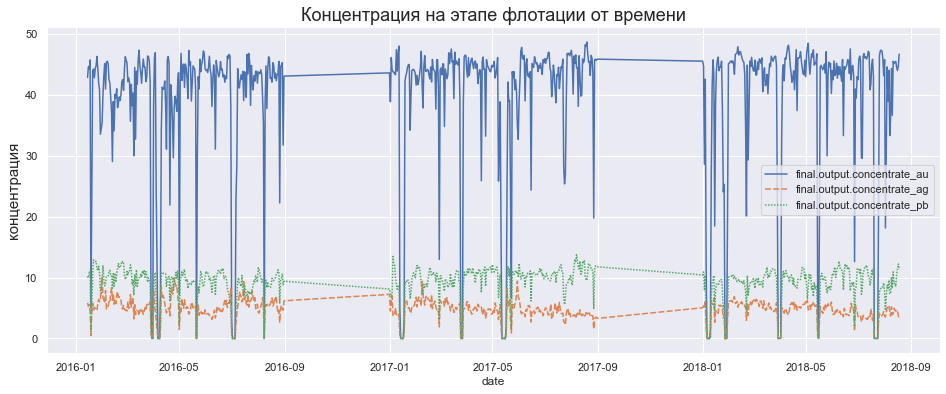

In [29]:
plot_met_time(met_concs[:,2], 'Концентрация на этапе флотации от времени')

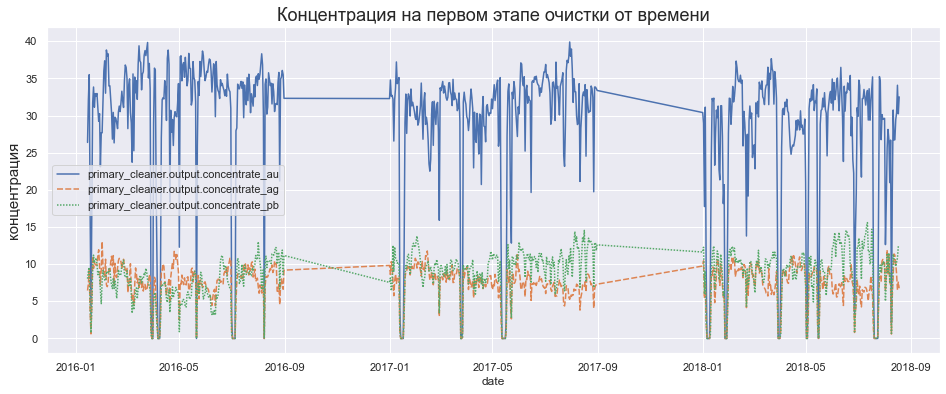

In [30]:
plot_met_time(met_concs[:,1], 'Концентрация на первом этапе очистки от времени')

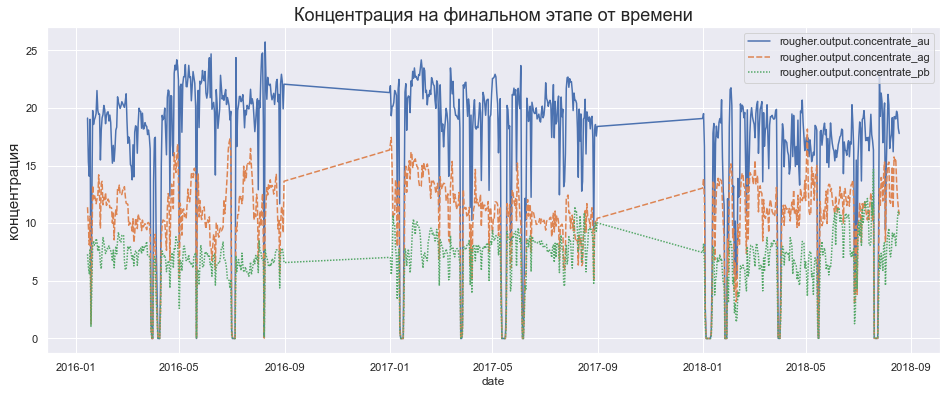

In [31]:
plot_met_time(met_concs[:,0], 'Концентрация на финальном этапе от времени')

- На графиках прослеживается увеличение концентрации золота в смеси с каждым новым этапом очистки.
- Также увеличивается концентрация золота относительно других металлов.
- На всех графиках концентрация металлов в среднем не сильно зависит от времени. Это говорит о стабильности тех. процесса и сырья.
- Теперь рассмотрим общий график для средних значений всех металлов на всех этапах технологического процесса.

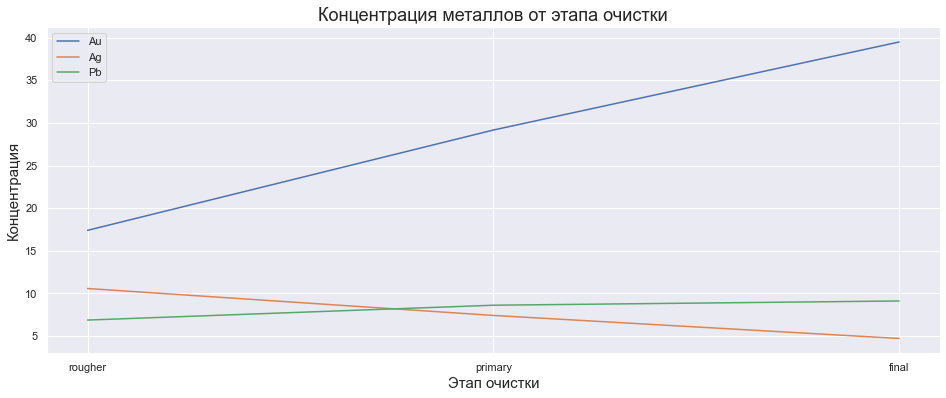

In [32]:
step_names = ['rougher', 'primary', 'final']
mets = ['Au', 'Ag', 'Pb']

sns.set()
f, axes = plt.subplots(1, 1, figsize=(16, 6))
axes.set_title('Концентрация металлов от этапа очистки', fontsize=18)
axes.set_ylabel('Концентрация', fontsize=15)
axes.set_xlabel('Этап очистки', fontsize=15)
for cols, met in zip(met_concs, mets):
    sns.lineplot(data = pd.Series(train[cols].mean().values, index=step_names),
                legend = 'full',
                label = met)
plt.gca().invert_xaxis()

- Данный график подтверждает сделанные ранее выводы. С каждым этапом очистки концентрация золота в смеси растёт, концентрация серебра немного падает, концентрация свинца немного растёт.

## 2.2 Сравнение распределений размеров гранул сырья

- С помощью гистограммы рассмотрим распределения размеров гранул сырья в обучающей и тестовой выборках
- Для более точной оценки возьмём средние за сутки значения размеров гранул

In [33]:
train_feed_size = train['rougher.input.feed_size'].groupby(train.index.floor('D')).agg('mean')
test_feed_size = test['rougher.input.feed_size'].groupby(test['rougher.input.feed_size'].index.floor('D')).agg('mean')

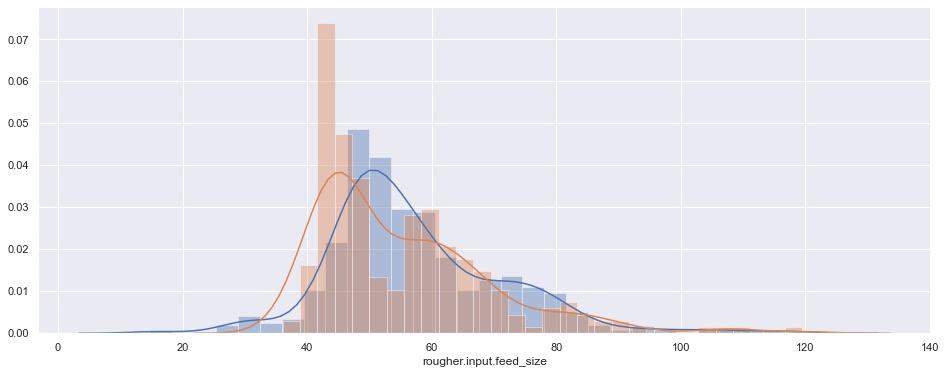

In [34]:
f, axes = plt.subplots(1, 1, figsize=(16, 6))
sns.distplot(train_feed_size.loc[train_feed_size < 150], bins=30)
sns.distplot(test_feed_size.loc[test_feed_size < 150], bins=30)

- Судя по графику, значения в обеих выборках не сильно отличаются. 
- Проверим гипотезу с помощью двустороннего t-теста. Дисперсии обоих распределений будем считать одинаковыми
- Гипотеза Н0:
    - "Средние за сутки значения размера гранул в обучающей выборке и тестовой выборке одинаковы"
- Сформулируем альтернативную гипотезу H1:
    - "Средние за сутки значения размера гранул в обучающей выборке и тестовой выборке не равны друг другу"
- Определим уровень значимости `alpha = 0.05`
- Для расчёта статистики разности и `p-value` будем использовать функцию `st.ttest_ind`

In [35]:
results = st.ttest_ind(train_feed_size,
                       test_feed_size,
                       equal_var=True)
print('p-value: {:.3f}'.format(results.pvalue))

p-value: 0.016


- p-value меньше уровня значимости 0.05. Необходимо отклонить нулевую гипотезу и считать распределения различными.
- Попробуем убрать выбросы в распределениях и провести t-test ещё раз.

In [36]:
train_q_75 = train['rougher.input.feed_size'].quantile(0.75)
train_q_25 = train['rougher.input.feed_size'].quantile(0.25)
test_q_75 = test['rougher.input.feed_size'].quantile(0.75)
test_q_25 = test['rougher.input.feed_size'].quantile(0.25)
train_min = train_q_25 - 3 * (train_q_75 - train_q_25)
train_max = train_q_75 + 3 * (train_q_75 - train_q_25)
test_min = test_q_25 - 3 * (test_q_75 - test_q_25)
test_max = test_q_75 + 3 * (test_q_75 - test_q_25)
print('Тренировочная выборка:')
print('    Нижняя граница выбросов: {:.2f}'.format(train_min))
print('    Верхняя граница выбросов: {:.2f}'.format(train_max))
print('Тестовая выборка:')
print('    Нижняя граница выбросов: {:.2f}'.format(test_min))
print('    Верхняя граница выбросов: {:.2f}'.format(test_max))

Тренировочная выборка:
    Нижняя граница выбросов: -6.10
    Верхняя граница выбросов: 119.11
Тестовая выборка:
    Нижняя граница выбросов: -9.38
    Верхняя граница выбросов: 114.91


In [37]:
results = st.ttest_ind(train_feed_size.loc[(train_feed_size > train_min) &
                                           (train_feed_size < train_max)],
                       test_feed_size.loc[(test_feed_size > test_min) &
                                          (test_feed_size > test_min)],
                       equal_var=True)
print('p-value: {:.3f}'.format(results.pvalue))

p-value: 0.208


- Без выбросов p-value = 0.21 > 0.05. Делаем вывод, что выборки не сильно отличаются друг от друга
- Признак "Размер гранул сырья" можно использовать для обучения модели.

## 2.3 Исследование суммарных концентраций веществ

- Рассчитаем суммарные концентрации веществ на разных стадиях (в сырье, после флотации и в финальном концентрате после двух этапов очистки).

In [38]:
train['feed_conc'] = train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] +\
            train['rougher.input.feed_sol'] + train['rougher.input.feed_au']
train['rougher_conc'] = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb'] +\
            train['rougher.output.concentrate_sol'] + train['rougher.output.concentrate_au']
train['final_conc'] = train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] +\
            train['final.output.concentrate_sol'] + train['final.output.concentrate_au']

In [39]:
sum_conc_cols = ['feed_conc', 'rougher_conc', 'final_conc']
plot_met_time(sum_conc_cols, 'Суммарная концентрация')

- Как и в пункте 2.1, наблюдаются аномалии (резкий спад суммарных концентраций до 0). В эти моменты целевые признаки не записывались. Данные бесполезны и подлежат удалению.
- Удалим все объекты, у которых хотя бы одно значение суммарной концентрации (на входе, после флотации или на выходе) меньше 31.

In [40]:
before_len = len(train)
train = train.loc[(train['feed_conc'] > 31) &
                  (train['rougher_conc'] > 31) &
                  (train['final_conc'] > 31)]

In [41]:
print("Удалено {} объектов".format(before_len - len(train)))

Удалено 2849 объектов


- Рассмотрим суммарные концентрации после удаления аномальных данных

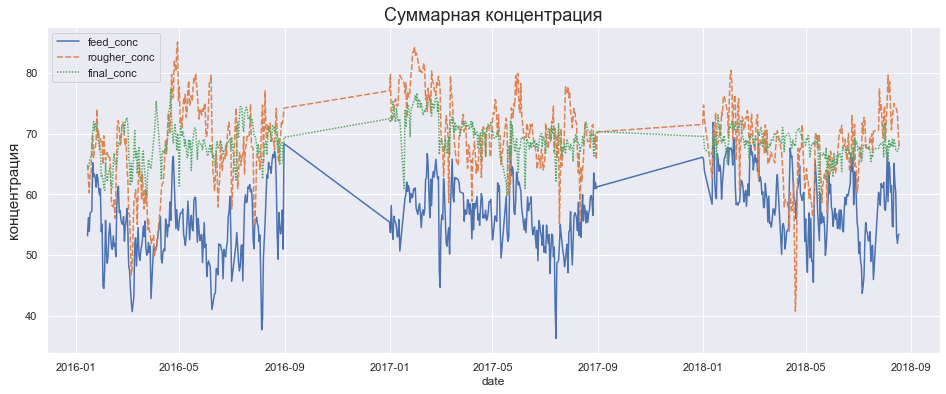

In [42]:
plot_met_time(sum_conc_cols, 'Суммарная концентрация')

In [43]:
train = train.drop(sum_conc_cols, axis = 1)

- Данные готовы к построению модели

### Выводы

- Проанализированы концентрации металлов (Au, Ag, Pb) на всех стадиях очистки для обучающей выборки. Выявлены аномалии (резкий спад концентраций до 0). Прямые линии на графиках показывают временные промежутки для тестовой выборки.
- Рассмотрены распределения гранул сырья на входе технологического процесса для обучающей и тестовой выборок. Двусторонний t-test показал, что распределения не сильно отличаются друг от друга при уровне значимости 0.05 (p-value = 0.21).
- Анализ суммарных концентраций подтвердил наличие аномальных данных. Все объекты с суммарной концентрацией смеси меньше 31 были удалены из тренировочной выборки. Всего удалено 2849 объектов (17% данных)

# 3. Модель

- Посмотрим на признаки обучающей выборки методом info()

In [44]:
train[model_columns].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13926 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   final.output.recovery                       13899 non-null  float64
 1   rougher.output.recovery                     13462 non-null  float64
 2   primary_cleaner.input.sulfate               13926 non-null  float64
 3   primary_cleaner.input.depressant            13926 non-null  float64
 4   primary_cleaner.input.feed_size             13926 non-null  float64
 5   primary_cleaner.input.xanthate              13926 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      13926 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13926 non-null  float64
 8   primary_cleaner.state.floatbank8_d_air      13926 non-null  float64
 9   rougher.input.feed_ag                       1392

- В целевом признаке `rougher.output.recovery` всё ещё много пропусков. Посмотрим на объекты эти объекты.

In [45]:
train.loc[train['rougher.output.recovery'].isna(), model_columns].head(50)

final.output.recovery  rougher.output.recovery  \
date                                                                  
2016-02-19 11:00:00              57.573980                      NaN   
2016-02-19 12:00:00              72.895003                      NaN   
2016-02-19 13:00:00              72.687989                      NaN   
2016-02-19 14:00:00              75.816384                      NaN   
2016-03-09 02:00:00              62.256772                      NaN   
2016-03-09 03:00:00              63.093404                      NaN   
2016-03-09 04:00:00              63.992990                      NaN   
2016-03-09 05:00:00              67.483486                      NaN   
2016-03-09 06:00:00              71.123115                      NaN   
2016-03-09 07:00:00              70.084607                      NaN   
2016-03-09 08:00:00              68.321025                      NaN   
2016-03-09 09:00:00              66.220951                      NaN   
2016-03-09 10:00:00              65.543486                      NaN   
2016-03-09 11:00:00              64.434283                      NaN   
2016-03-10 04:00:00              68.009888                      NaN   
2016-03-10 05:00:00              68.577040                      NaN   
2016-03-10 06:00:00              66.888838                      NaN   
2016-03-10 07:00:00              69.609595                      NaN   
2016-03-10 08:00:00              75.592370                      NaN   
2016-03-10 09:00:00              65.861924                      NaN   
2016-04-10 22:00:00              59.913690                      NaN   
2016-04-22 13:00:00              69.083843                      NaN   
2016-04-22 14:00:00              68.939448                      NaN   
2016-04-22 15:00:00              64.092222                      NaN   
2016-04-22 16:00:00              61.022250                      NaN   
2016-04-22 17:00:00              64.618921                      NaN   
2016-04-22 18:00:00              59.251838                      NaN   
2016-04-22 19:00:00              63.053808                      NaN   
2016-04-22 20:00:00              65.546363                      NaN   
2016-04-22 21:00:00              68.831776                      NaN   
2016-04-22 22:00:00              67.869572                      NaN   
2016-04-22 23:00:00              62.720674                      NaN   
2016-04-23 00:00:00              70.450638                      NaN   
2016-04-23 01:00:00              71.509774                      NaN   
2016-04-23 02:00:00              70.860171                      NaN   
2016-04-23 03:00:00              70.017095                      NaN   
2016-04-23 04:00:00              69.498245                      NaN   
2016-04-23 05:00:00              64.828037                      NaN   
2016-04-23 06:00:00              64.256073                      NaN   
2016-04-23 07:00:00              65.100061                      NaN   
2016-04-23 10:00:00              68.413675                      NaN   
2016-04-23 10:59:59              67.790864                      NaN   
2016-04-23 11:59:59              67.589483                      NaN   
2016-04-23 12:59:59              68.816028                      NaN   
2016-04-23 13:59:59              69.528366                      NaN   
2016-04-23 17:59:59              66.473723                      NaN   
2016-04-23 18:59:59              65.787813                      NaN   
2016-04-24 00:59:59              69.142168                      NaN   
2016-04-24 01:59:59              69.491816                      NaN   
2016-04-24 02:59:59              68.510204                      NaN   

                     primary_cleaner.input.sulfate  \
date                                                 
2016-02-19 11:00:00                     118.575500   
2016-02-19 12:00:00                     114.144683   
2016-02-19 13:00:00                     149.489157   
2016-02-19 14:00:00                     165.634904   
2016

- Данный признак не получится заполнить на основе исторических данных. Многие данные пропущены на протяжении 10 часов подряд и более. Удалим данные объекты, чтобы не вносить ошибку в модель.
- В целевом признаке `final.output.recovery` осталось несколько пропусков, многие из которых идут подряд по времени. Также удаляем их.
- Создадим две отдельные обучающие выборки: для предсказания эффекивности обогащения после флотации и после очистки

In [46]:
train_r = train.loc[~train['rougher.output.recovery'].isna()]
train_f = train.loc[~train['final.output.recovery'].isna()]

In [47]:
print('Количество объектов обучающей выборки: {}'.format(len(train_r)))
print('Количество объектов обучающей выборки: {}'.format(len(train_f)))

Количество объектов обучающей выборки: 13462
Количество объектов обучающей выборки: 13899


- Для предсказания эффективности обогащения на этапе флотации могут быть использованы только признаки, доступные в технологическом процессе на момент вычисления данного параметра (признаки с префиксом `rougher`).

In [48]:
rougher_columns = []
pattern = re.compile('rougher')
print('Признаки для предсказания эффективности обогащения на этапе флотации:')
for column in list(test.columns):
    if re.match(pattern, column):
        rougher_columns.append(column)
        print(' - ', column)

Признаки для предсказания эффективности обогащения на этапе флотации:
 -  rougher.input.feed_ag
 -  rougher.input.feed_pb
 -  rougher.input.feed_rate
 -  rougher.input.feed_size
 -  rougher.input.feed_sol
 -  rougher.input.feed_au
 -  rougher.input.floatbank11_sulfate
 -  rougher.input.floatbank11_xanthate
 -  rougher.state.floatbank10_a_air
 -  rougher.state.floatbank10_a_level
 -  rougher.state.floatbank10_c_air
 -  rougher.state.floatbank10_e_level
 -  rougher.state.floatbank10_f_air


## 3.1 Функция итоговой sMAPE

- Напишем функции для вычисления метрики качества final_smape (финальное симметричное среднее абсолютное процентное отклонение)

In [49]:
def smape(true, predict):
    """
    input:        true    - реальные значения целевого признака 
                  predict - предсказания модели
    output:       smape - симметричное среднее абсолютное процентное отклонение
    description:  функция рассчитывает и возвращает метрику smape 
                  по реальным значениям целевого признака и предсказаниям модели
    """
    return 1 / len(true) * sum( abs(true - predict) / ( (abs(true) + abs(predict)) * 0.5) ) * 100

In [50]:
def final_smape(smape_r, smape_f):
    """
    input:        r_true    - реальные значения целевого признака (эффективность обогащения после флотации)
                  r_predict - предсказания модели (финальная эффективность обогащения)
                  f_true    - реальные значения целевого признака (эффективность обогащения после флотации)
                  f_predict - предсказания модели (финальная эффективность обогащения)
    output:       final smape - финальное симметричное среднее абсолютное процентное отклонение
    description:  функция рассчитывает и возвращает метрику final smape 
                  по реальным значениям целевых признаков и предсказаниям моделей
    """
    return 0.25 * smape_r + 0.75 * smape_f

## 3.2 Обучение и оценка качества моделей

- Финальная метрика final_smape зависит линейно от smape после флотации и после очистки. Максимизировав их обе отдельно, сможем добиться максимума финальной метрики. Так что обучать и валидировать модели можно независимо друг от друга.
- Выделим в обучающей выборке признаки и целевые признаки

In [51]:
X_r = train_r[rougher_columns]
X_f = train_f[input_columns]
y_r = train_r['rougher.output.recovery']
y_f = train_f['final.output.recovery']
test_r = test[rougher_columns]
test_f = test[input_columns]

- Убедимся, что обучающие и тестовые выборки содержат одинаковые признаки

In [52]:
print('Сравнение признаков для модели на этапе флотации:', set(X_r) == set(test_r))
print('Сравнение признаков для модели на этапе очистки:', set(X_f) == set(test_f))

Сравнение признаков для модели на этапе флотации: True
Сравнение признаков для модели на этапе очистки: True


- Масштабируем признаки на обучающей и тестовой выборках с помощью метода `StandardScaler`

In [53]:
ss_r = StandardScaler()
ss_f = StandardScaler()
ss_r.fit(X_r)
ss_f.fit(X_f)

X_r = pd.DataFrame(ss_r.transform(X_r), columns = rougher_columns)
X_f = pd.DataFrame(ss_f.transform(X_f), columns = input_columns)
test_f_ind = test.index
test_r_ind = test_r.index
test_r = pd.DataFrame(ss_r.transform(test_r), columns = rougher_columns, index = test_r_ind)
test_f = pd.DataFrame(ss_f.transform(test), columns = input_columns, index = test_f_ind)

- Необходимо обучить две модели для двух целевых признаков `rougher.output.recovery` и `final.output.recovery`. 
- Для оценки качества модели будем использовать кросс валидацию.

- Модель **Линейная регресия**

In [54]:
# инициализируем модель
lm_r = LinearRegression()

# Обучим модель для этапа флотации
smape_lm_r = cross_val_score(lm_r, X_r, y_r, 
                             scoring = make_scorer(smape),
                             cv = 5,
                             n_jobs = -1).mean()

In [55]:
lm_f = LinearRegression()

# Обучим модель для финального этапа
smape_lm_f = cross_val_score(lm_f, X_f, y_f, 
                             scoring = make_scorer(smape),
                             cv = 5,
                             n_jobs = -1).mean()

In [56]:
print('Линейная регрессия:')
print('    sMAPE rougher: {:.2f} %'.format(smape_lm_r))
print('    sMAPE cleaner: {:.2f} %'.format(smape_lm_f))
print('Final sMAPE: {:.2f} %'.format(final_smape(smape_lm_r, smape_lm_f)))

Линейная регрессия:
    sMAPE rougher: 6.44 %
    sMAPE cleaner: 9.86 %
Final sMAPE: 9.01 %


- Модель **Elastic-Net**

- Подберём гиперпараметры для модели с помощью техники `GridSearchCV` библиотеки sklearn. Она последовательно обучает модель на всех заданных комбинациях гиперпараметров, используя кросс валидацию. Далее возвращает комбинацию гиперпараметров, с которыми модель достигла наилучшего значения метрики качества.

In [57]:
l1_ratios = np.linspace(0, 1, 11, endpoint=True)
alphas = np.linspace(0.1, 1, 10, endpoint=True)
param_grid = {'l1_ratio': l1_ratios,
              'alpha': alphas
             }
# инициализируем модель ElasticNet
en_r = ElasticNet()

# инициализируем GridSearchCV
grid_search_r = GridSearchCV(estimator = en_r, 
                           param_grid = param_grid, 
                           cv = 5, 
                           n_jobs = -1, 
                           verbose = 2, 
                           scoring = make_scorer(smape))
grid_search_r.fit(X_r, y_r)

print(grid_search_r.best_params_)
print('    sMAPE rougher: {:.2f} %'.format(grid_search_r.best_score_))

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 535 out of 550 | elapsed:    5.0s remaining:    0.0s


{'alpha': 1.0, 'l1_ratio': 1.0}
    sMAPE rougher: 6.73 %


[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    5.5s finished


In [58]:
# инициализируем модель ElasticNet
en_f = ElasticNet()

# инициализируем GridSearchCV
grid_search_f = GridSearchCV(estimator = en_f, 
                           param_grid = param_grid, 
                           cv = 5, 
                           n_jobs = -1, 
                           verbose = 2, 
                           scoring = make_scorer(smape))
grid_search_f.fit(X_f, y_f)

print(grid_search_f.best_params_)
print('    sMAPE cleaner:   {:.2f} %'.format(grid_search_f.best_score_))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:   20.5s finished


{'alpha': 0.1, 'l1_ratio': 0.0}
    sMAPE cleaner:   9.18 %


c:\users\андрей\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393086.5007561558, tolerance: 107.74133210946422
  model = cd_fast.enet_coordinate_descent(


- Исходя из параметров, нйденных GridSearchCV, стоит поробовать **модель Lasso** с L1 регуляризацией.

In [59]:
ls_r = Lasso(alpha=0.2)
# Обучим модель для финального этапа
smape_ls_r = cross_val_score(ls_r, X_r, y_r, 
                                scoring = make_scorer(smape),
                                cv = 5,
                                n_jobs = -1).mean()
smape_ls_r

6.267661912155236

In [60]:
ls_f = Lasso(alpha=0.4)
# Обучим модель для финального этапа
smape_ls_f = cross_val_score(ls_f, X_f, y_f, 
                                scoring = make_scorer(smape),
                                cv = 5,
                                n_jobs = -1).mean()
smape_ls_f

8.832950667624115

In [61]:
print('Модель Lasso:')
print('    sMAPE rougher: {:.2f} %'.format(smape_ls_r))
print('    sMAPE cleaner: {:.2f} %'.format(smape_ls_f))

Модель Lasso:
    sMAPE rougher: 6.27 %
    sMAPE cleaner: 8.83 %


In [62]:
print('Final sMAPE: {:.2f} %'.format(final_smape(smape_ls_r, smape_ls_f)))

Final sMAPE: 8.19 %


- **Перемешивание признаков**

- Попробуем увеличить качество модели путём исключения признаков, мало влияющих на целевой признак. Воспользуемся методом перемешивания признаков. По очереди будем перемешивать каждый признак на валидационной выборке и следить за изменениями качества предсказаний модели. воспользуемся методом `permutation_importance` библиотеки sklearn

In [63]:
def feature_reduction(X, y, alpha, num_features, label):
    """
    input:       X - признаки для модели Lasso
                 y - целевой признак
                 alpha - параметр регуляризации для модели Lasso
                 num_features - количество признаков, которое необходимо оставить в модели
                 label - название этапа технологического процесса
    output:      chosen_cols - выбранные признаки для модели
                 smape_ls_red - значение метрики smape, рассчитанное на модели с применением кросс-валидации
    description: Функция делит входные данные на обучающую и валидационную выборки для отбора признаков 
                 методом перемешивания. Функция использует метод `permutation_importance` из библиотеки sklearn.
                 Выводятся признаки в порядке убывания значимости для целевого признака (также выводятся средняя 
                 значимость и стандартное отклонение). После производится отбор num_features наиболее важных
                 признаков. Модель Lasso обучается на новом пространстве пизнаков с применением кросс-валидации.
                 Выводится метрика smape.
    """
    # разделение выборки на обучающую и валидационную для расчёта важности признаков
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    # обучение модели Lasso
    ls = Lasso(alpha=alpha)
    ls.fit(X_train, y_train)
    
    # расчёт важности признаков методом перемешивания
    p_i = permutation_importance(ls, X_valid, y_valid,
                                 n_repeats=30,
                                 random_state=42)
    
    # вывод признаков в порядке убывания важности
    for i in p_i.importances_mean.argsort()[::-1]:
        if p_i.importances_mean[i] - 2 * p_i.importances_std[i] > 0:
            print(f"{X_valid.columns[i]:<50}"
                  f"{p_i.importances_mean[i]:.3f}"
                  f" +/- {p_i.importances_std[i]:.3f}")  
    
    # обучение модели на всех данных с уменьшенным количеством признаков
    chosen_cols = p_i.importances_mean.argsort()[::-1][:num_features]
    X_red = X.iloc[:, chosen_cols]
    smape_ls_red = cross_val_score(ls, X_red, y, 
                                    scoring = make_scorer(smape),
                                    cv = 5,
                                    n_jobs = -1).mean()
    print()
    print(' sMAPE {} : {:.2f} %'.format(label, smape_ls_red))    
    return chosen_cols, smape_ls_red

In [64]:
rougher_features, smape_ls_r_red = feature_reduction(X_r, y_r, alpha=0.2, num_features=7, label='флотация')

rougher.state.floatbank10_a_level                 0.099 +/- 0.006
rougher.input.feed_ag                             0.069 +/- 0.005
rougher.input.floatbank11_xanthate                0.067 +/- 0.004
rougher.input.feed_sol                            0.055 +/- 0.005
rougher.input.feed_pb                             0.033 +/- 0.003
rougher.input.feed_au                             0.029 +/- 0.002
rougher.input.floatbank11_sulfate                 0.019 +/- 0.002
rougher.state.floatbank10_c_air                   0.019 +/- 0.002
rougher.state.floatbank10_f_air                   0.004 +/- 0.001
rougher.input.feed_rate                           0.004 +/- 0.001
rougher.state.floatbank10_a_air                   0.003 +/- 0.001
rougher.state.floatbank10_e_level                 0.002 +/- 0.001

 sMAPE флотация : 5.93 %


In [65]:
cleaner_features, smape_ls_f_red = feature_reduction(X_f, y_f, alpha=0.4, num_features=10, label='очисткка')

rougher.input.floatbank11_xanthate                0.074 +/- 0.006
rougher.input.feed_au                             0.044 +/- 0.003
primary_cleaner.input.sulfate                     0.039 +/- 0.004
rougher.input.floatbank11_sulfate                 0.021 +/- 0.002
rougher.input.feed_sol                            0.014 +/- 0.002
rougher.input.feed_ag                             0.013 +/- 0.002
secondary_cleaner.state.floatbank3_a_air          0.012 +/- 0.002
primary_cleaner.state.floatbank8_a_air            0.006 +/- 0.001
secondary_cleaner.state.floatbank4_a_air          0.005 +/- 0.001
rougher.state.floatbank10_c_air                   0.003 +/- 0.001
primary_cleaner.input.feed_size                   0.002 +/- 0.000
primary_cleaner.input.xanthate                    0.001 +/- 0.000
primary_cleaner.state.floatbank8_b_level          0.000 +/- 0.000

 sMAPE очисткка : 8.70 %


In [66]:
print('Итоговое sMAPE на кросс-валидации: {:.2f} %'.format(final_smape(smape_ls_r_red, smape_ls_f_red)))

Итоговое sMAPE на кросс-валидации: 8.01 %


In [67]:
X_r_red = X_r.iloc[:,rougher_features]
print('Итоговые признаки для модели на этапе флотации:')
print(pd.Series(X_r_red.columns))

Итоговые признаки для модели на этапе флотации:
0     rougher.state.floatbank10_a_level
1                 rougher.input.feed_ag
2    rougher.input.floatbank11_xanthate
3                rougher.input.feed_sol
4                 rougher.input.feed_pb
5                 rougher.input.feed_au
6     rougher.input.floatbank11_sulfate
dtype: object


In [68]:
X_f_red = X_f.iloc[:,cleaner_features]
print('Итоговые признаки для модели на этапе очистки:')
print(pd.Series(X_f_red.columns))

Итоговые признаки для модели на этапе очистки:
0          rougher.input.floatbank11_xanthate
1                       rougher.input.feed_au
2               primary_cleaner.input.sulfate
3           rougher.input.floatbank11_sulfate
4                      rougher.input.feed_sol
5                       rougher.input.feed_ag
6    secondary_cleaner.state.floatbank3_a_air
7      primary_cleaner.state.floatbank8_a_air
8    secondary_cleaner.state.floatbank4_a_air
9             rougher.state.floatbank10_c_air
dtype: object


## 3.3 Тестирование модели

- Проверим качество модели на тестовой выборке.

In [69]:
# из исходных данных сохраним целевые признаки для тестовой выборки
y_true_r = full.loc[test.index, 'rougher.output.recovery'].dropna()
y_true_f = full.loc[test.index, 'final.output.recovery'].dropna()
# создадим тестовые выборки признаков с валидными индексами для обоих этапов
test_r = test_r.loc[y_true_r.index]
test_f = test_f.loc[y_true_f.index]
test_r = test_r[X_r_red.columns]
test_f = test_f[X_f_red.columns]

In [70]:
# Инициализируем модели Lasso с подобранными ранее параметрами
model_r = Lasso(alpha=0.2)
model_f = Lasso(alpha=0.4)

# Обучене моделей и получение предсказаний
model_r.fit(X_r_red, y_r)
model_f.fit(X_f_red, y_f)
predict_r = model_r.predict(test_r)
predict_f = model_f.predict(test_f)

print('sMAPE флотации на тестовой выборке: {:.2f} %'.format(smape(y_true_r, predict_r)))
print('sMAPE очистки на тестовой выборке:  {:.2f} %'.format(smape(y_true_f, predict_f)))
smape_fin = final_smape(smape(y_true_r, predict_r), smape(y_true_f, predict_f))
print('Итоговая sMAPE на тестовой выборке: {:.2f} %'.format(smape_fin))

sMAPE флотации на тестовой выборке: 8.15 %
sMAPE очистки на тестовой выборке:  9.68 %
Итоговая sMAPE на тестовой выборке: 9.30 %


- Сравним полученную модель с константной. Возьмём средние значения целевых признаков в обучающей выборке и посчитаем итоговое sMAPE на тестовых данных.

In [71]:
dummy_pred_r = np.array([train_r['rougher.output.recovery'].mean() for _ in range(len(y_true_r))])
dummy_pred_f = np.array([train_f['final.output.recovery'].mean() for _ in range(len(y_true_f))])

In [73]:
print('Константная модель')
print('sMAPE флотации на тестовой выборке: {:.2f} %'.format(smape(y_true_r, dummy_pred_r)))
print('sMAPE очистки на тестовой выборке:  {:.2f} %'.format(smape(y_true_f, dummy_pred_f)))
smape_dummy = final_smape(smape(y_true_r, dummy_pred_r), smape(y_true_f, dummy_pred_f))
print('Итоговая sMAPE на тестовой выборке: {:.2f} %'.format(smape_dummy))

Константная модель
sMAPE флотации на тестовой выборке: 9.08 %
sMAPE очистки на тестовой выборке:  10.80 %
Итоговая sMAPE на тестовой выборке: 10.37 %


- Метрика sMAPE на обученной модели на 1% ниже, чем на константной модели.

### Выводы

- Данные обучены на моделях линейной регрессии, ElasticNet и Lasso.
- Отдельно оптимизировались модели для эффекивности обогащения после флотации и после очистки.
- Применены техники кросс-валидации для оценки качества моделей и GridSearchCV для поиска оптимальных гиперпараметров.
- Лучший результат дала модель Lasso. 
- Также был произведён отбор признаков для обучения обеих моделей методом перемешивания.
    - sMAPE флотация: 5.93 %
    - sMAPE очистка:  8.70 %
    - sMAPE итоговое: 8.01 %      
- sMAPE на тестовой выборке:
    - sMAPE флотация: 8.15 %
    - sMAPE очистка:  9.68 %
    - **sMAPE итоговое: 9.30 %**
- Итоговое sMAPE на константной модели 10.37 %

# 4. Общий вывод

**1)**  
- Данные успешно проанализированы. Показатель эффективности обогащения рассчитан корректно.
- Отобраны признаки, избыточные и нерелевантные для модели (некоторые параметры, характеризующие текущее состояние этапов технологического процесса). В случае изменения технологического процесса поведение данных признаков может измениться, и будет необходимо обновить модель.
- Для актуальных признаков были заполнены пропуски на основе имеющихся исторических данных.  
  
**2)**  
- Проанализированы концентрации металлов (Au, Ag, Pb), а также суммарные концентрации веществ на всех стадиях очистки.
- Рассмотрены распределения гранул сырья на входе технологического процесса для обучающей и тестовой выборок. Двусторонний t-test показал, что распределения не сильно отличаются друг от друга при уровне значимости 0.05 (p-value = 0.59).
- Анализ суммарных концентраций подтвердил наличие аномальных данных. Все объекты с суммарной концентрацией смеси меньше 31 были удалены из тренировочной выборки. Всего удалено 2849 объектов (17% данных)  
  
**3)**  
- Данные обучены на моделях линейной регрессии, ElasticNet и Lasso.
- Отдельно оптимизировались модели для эффекивности обогащения после флотации и после очистки.
- Применены техники кросс-валидации для оценки качества моделей и GridSearchCV для поиска оптимальных гиперпараметров.
- Произведён отбор признаков для обучения обеих моделей методом перемешивания.
- sMAPE на тестовой выборке (модель Lasso):
    - sMAPE флотация: 8.15 %
    - sMAPE очистка:  9.68 %
    - **sMAPE итоговое: 9.30 %**
- Метрика sMAPE на обученной модели на 1% ниже, чем на константной модели.